In [1]:
import os
import glob
import torch
import pandas as pd
import numpy as np
from pathlib import Path

# add code directory to path
import sys
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')

from torch_models import NegativeBinomialRegressionModel
from metrics import top_k_onehot_indicator
from functools import partial
from torch_models import NegativeBinomialRegressionModel
from metrics import top_k_onehot_indicator
from torch_perturb.perturbations import perturbed
from torch_models import torch_bpr_uncurried, deterministic_bpr
from matplotlib import pyplot as plt


2025-01-29 14:38:45.844888: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 14:38:45.890410: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-29 14:38:45.890440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-29 14:38:45.891651: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 14:38:45.899862: I tensorflow/core/platform/cpu_feature_guar

In [2]:

def load_data(data_dir, bird=False):
    """Load and process training, validation, and test data."""

    if bird:
        bird = 'bird_'
    else:
        bird =  ''
    # Load data
    train_X_df = pd.read_csv(os.path.join(data_dir, f'{bird}train_x.csv'), index_col=[0,1])
    train_Y_df = pd.read_csv(os.path.join(data_dir, f'{bird}train_y.csv'), index_col=[0,1])
    val_X_df = pd.read_csv(os.path.join(data_dir, f'{bird}valid_x.csv'), index_col=[0,1])
    val_Y_df = pd.read_csv(os.path.join(data_dir, f'{bird}valid_y.csv'), index_col=[0,1])
    test_X_df = pd.read_csv(os.path.join(data_dir, f'{bird}test_x.csv'), index_col=[0,1])
    test_Y_df = pd.read_csv(os.path.join(data_dir, f'{bird}test_y.csv'), index_col=[0,1])
    
    def convert_df_to_3d_array(df):
        geoids = sorted(df.index.get_level_values('geoid').unique())
        timesteps = sorted(df.index.get_level_values('timestep').unique())
        geoid_to_idx = {geoid: idx for idx, geoid in enumerate(geoids)}
        
        num_timesteps = len(timesteps)
        print(f'Num timesteps: {num_timesteps}')
        num_locations = len(geoids)
        num_features = len(df.columns)
        X = np.zeros((num_timesteps, num_locations, num_features))
        
        for (geoid, timestep), row in df.iterrows():
            t_idx = timesteps.index(timestep)
            g_idx = geoid_to_idx[geoid]
            X[t_idx, g_idx, :] = row.values
            
        return X, geoids, timesteps

    def convert_y_df_to_2d_array(y_df, geoids, timesteps):
        num_timesteps = len(timesteps)
        num_locations = len(geoids)
        y = np.zeros((num_timesteps, num_locations))
        geoid_to_idx = {geoid: idx for idx, geoid in enumerate(geoids)}
        
        for (geoid, timestep), value in y_df.iloc[:, 0].items():
            t_idx = timesteps.index(timestep)
            g_idx = geoid_to_idx[geoid]
            y[t_idx, g_idx] = value
            
        return y

    # Process training data
    train_X, geoids, timesteps = convert_df_to_3d_array(train_X_df)#.drop(columns='timestep.1'))
    train_time = np.array([timesteps] * len(geoids)).T
    train_y = convert_y_df_to_2d_array(train_Y_df, geoids, timesteps)

    # Process validation data
    val_X, val_geoids, val_timesteps = convert_df_to_3d_array(val_X_df)#.drop(columns='timestep.1'))
    val_time = np.array([val_timesteps] * len(val_geoids)).T
    val_y = convert_y_df_to_2d_array(val_Y_df, val_geoids, val_timesteps)

    # Process test data
    test_X, test_geoids, test_timesteps = convert_df_to_3d_array(test_X_df)#.drop(columns='timestep.1'))
    test_time = np.array([test_timesteps] * len(test_geoids)).T
    test_y = convert_y_df_to_2d_array(test_Y_df, test_geoids, test_timesteps)

    return {
        'train': (torch.tensor(train_X, dtype=torch.float32), 
                 torch.tensor(train_time, dtype=torch.float32),
                 torch.tensor(train_y, dtype=torch.float32)),
        'val': (torch.tensor(val_X, dtype=torch.float32),
               torch.tensor(val_time, dtype=torch.float32),
               torch.tensor(val_y, dtype=torch.float32)),
        'test': (torch.tensor(test_X, dtype=torch.float32),
                torch.tensor(test_time, dtype=torch.float32),
                torch.tensor(test_y, dtype=torch.float32))
    }

In [5]:
location = 'cook'

dirs = {'MA': ('/cluster/tufts/hugheslab/datasets/NSF_OD/cleaned/long/MA', '/cluster/tufts/hugheslab/kheuto01/opioid_hpc_test_long_big/MA/'),
        'cook': ('/cluster/tufts/hugheslab/datasets/NSF_OD/cleaned/cook', '/cluster/tufts/hugheslab/kheuto01/opioid_hpc_test_long_big/cook/'),}
data_dir, base_dir = dirs[location]
K=100

K=75
location ='asurv'
data_dir = '/cluster/tufts/hugheslab/fmuenc01/code/prob_diff_topk/data_dir/asurv/2monthly_ctxtSize5_small_5yrTrain'
base_dir = f'/cluster/tufts/hugheslab/fmuenc01/bird_zero_rand_K{K}_8000_bigFix_nll_shortcut/{location}'
# Find all experiment directories


exp_dirs = glob.glob(os.path.join(base_dir, "K*"))

device = 'cuda'
#K=100
data = load_data(data_dir,bird=True)

# Move data to device
train_data = tuple(x.to(device) for x in data['train'])
val_data = tuple(x.to(device) for x in data['val'])
test_data = tuple(x.to(device) for x in data['test'])


num_ranking_samples = 1000
num_trials = 1000

Num timesteps: 15
Num timesteps: 6
Num timesteps: 6


In [11]:
data['train'][0].shape

torch.Size([33, 2156, 8])

In [7]:
train_X_df = pd.read_csv(os.path.join(data_dir, f'bird_train_x.csv'), index_col=[0,1])

In [8]:
train_X_df

,,lat,long,month_indicator,prev_counts_05back,prev_counts_04back,prev_counts_03back,prev_counts_02back,prev_counts_01back
geoid,timestep,,,,,,,,
0,143,27.968906,-97.038084,1,0.0,0.0,0.0,0.0,0.0
1,143,27.973417,-97.038002,1,0.0,0.0,0.0,0.0,0.0
2,143,27.977928,-97.037921,1,0.0,0.0,0.0,0.0,0.0
3,143,27.982439,-97.037839,1,0.0,0.0,0.0,0.0,0.0
4,143,27.986950,-97.037757,1,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2151,175,28.272782,-96.573892,3,0.0,0.0,0.0,0.0,0.0
2152,175,28.268182,-96.568901,3,0.0,0.0,0.0,0.0,0.0
2153,175,28.272691,-96.568798,3,0.0,0.0,0.0,0.0,0.0


In [7]:
import os
import torch
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import gaussian_kde
# Function to run the experiment with a given seed
def run_experiment(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    # skip this block if output csv exists
    if os.path.exists(f'results_seed_{seed}_{location}_{K}.csv'):
        safe_globals = {
            'array': np.array,
            'float32': np.float32,
            'nan': np.nan  # Add float32 to safe globals
        }

        def type_converter(x):
            if pd.isna(x):
                return np.nan
            try:
                # Try direct eval first
                return eval(x, safe_globals)
            except (SyntaxError, ValueError):
                try:
                    # Try parsing as literal string list
                    return ast.literal_eval(x)
                except (SyntaxError, ValueError):
                    return x

        # Use in read_csv
        results_df = pd.read_csv(f'results_seed_{seed}_{location}.csv', converters={
            'avg_train_bpr': type_converter,
            'avg_val_bpr': type_converter,
            'avg_test_bpr': type_converter,
            'trial_train_bprs': type_converter,
            'trial_val_bprs': type_converter,
            'trial_test_bprs': type_converter,
            'val_nll': type_converter,
            'test_nll': type_converter,
            'param_1': type_converter,
            'param_2': type_converter,
            'param_8': type_converter
        })
        trial_train_bprs = results_df['trial_train_bprs'].values
        trial_test_bprs = results_df['trial_test_bprs'].values
        trial_val_bprs = results_df['trial_val_bprs'].values
        
    else:
        
        model_paths = []
        avg_train_bprs = []
        avg_val_bprs = []
        avg_test_bprs = []
        trial_train_bprs = []
        trial_val_bprs = []
        trial_test_bprs = []
        train_nlls = []
        val_nlls = []
        test_nlls = []
        params_list = []
        max_param_len = 0

        for e, exp_dir in enumerate(exp_dirs):
            # print progress every 25 experiments
            if e % 5 == 0:
                print(f'Processing experiment {e} of {len(exp_dirs)}')
            # Extract hyperparameters from directory name
            dir_name = os.path.basename(exp_dir)
            params = [param.split('_') for param in dir_name.split('_')]
            param_len = len(params)
            if param_len > max_param_len:
                max_param_len = param_len
            
            # Load model
            model_path = os.path.join(exp_dir, 'best_model.pth')
            if not os.path.exists(model_path):
                continue
                
            # Initialize model with correct parameters
            model = NegativeBinomialRegressionModel(
                num_locations=data['train'][0].shape[1],
                num_fixed_effects=data['train'][0].shape[2]
            ).to(device)
            
            # Load saved weights
            model.load_state_dict(torch.load(model_path, map_location=device))
            model.eval()

            trial_train_bpr = []
            trial_val_bpr = []
            trial_test_bpr = []
            train_nll = -model.log_likelihood(train_data[2], train_data[0], train_data[1]).detach().cpu().numpy()
            val_nll = -model.log_likelihood(val_data[2], val_data[0], val_data[1]).detach().cpu().numpy()
            test_nll = -model.log_likelihood(test_data[2], test_data[0], test_data[1]).detach().cpu().numpy()

            for trial in range(num_trials):

                train_dist = model(train_data[0], train_data[1])
                y_sample_TMS = train_dist.sample((num_ranking_samples,)).permute(1, 0, 2)
                ratio_rating_TMS = y_sample_TMS / y_sample_TMS.sum(dim=-1, keepdim=True)
                ratio_rating_TS = ratio_rating_TMS.mean(dim=1)
                det_bpr = deterministic_bpr(ratio_rating_TS, train_data[2], K=K)
                det_bpr = torch.mean(det_bpr).cpu().numpy()
                trial_train_bpr.append(det_bpr)


                val_dist = model(val_data[0], val_data[1])
                y_sample_TMS = val_dist.sample((num_ranking_samples,)).permute(1, 0, 2)
                ratio_rating_TMS = y_sample_TMS / y_sample_TMS.sum(dim=-1, keepdim=True)
                ratio_rating_TS = ratio_rating_TMS.mean(dim=1)
                det_bpr = deterministic_bpr(ratio_rating_TS, val_data[2], K=K)
                det_bpr = torch.mean(det_bpr).cpu().numpy()
                trial_val_bpr.append(det_bpr)

                test_dist = model(test_data[0], test_data[1])
                y_sample_TMS = test_dist.sample((num_ranking_samples,)).permute(1, 0, 2)
                ratio_rating_TMS = y_sample_TMS / y_sample_TMS.sum(dim=-1, keepdim=True)
                ratio_rating_TS = ratio_rating_TMS.mean(dim=1)
                det_bpr = deterministic_bpr(ratio_rating_TS, test_data[2], K=K)
                det_bpr = torch.mean(det_bpr).cpu().numpy()
                trial_test_bpr.append(det_bpr)
            
            avg_train_bpr = np.mean((trial_train_bpr))
            avg_val_bpr = np.mean((trial_val_bpr))
            avg_test_bpr = np.mean((trial_test_bpr))

            model_paths.append(model_path)
            avg_train_bprs.append(avg_train_bpr)
            avg_val_bprs.append(avg_val_bpr)
            avg_test_bprs.append(avg_test_bpr)
            trial_train_bprs.append(trial_train_bpr)
            trial_val_bprs.append(trial_val_bpr)
            trial_test_bprs.append(trial_test_bpr)
            train_nlls.append(train_nll)
            val_nlls.append(val_nll)
            test_nlls.append(test_nll)
            params_list.append(params)

        # Create a dataframe to store the results
        results = pd.DataFrame({
            'model_path': model_paths,
            'avg_train_bpr': avg_train_bprs,
            'avg_val_bpr': avg_val_bprs,
            'avg_test_bpr': avg_test_bprs,
            'trial_train_bprs': trial_train_bprs,
            'trial_val_bprs': trial_val_bprs,
            'trial_test_bprs': trial_test_bprs,
            'train_nll': train_nlls,
            'val_nll': val_nlls,
            'test_nll': test_nlls
        })

        # Add params to the dataframe
        # name params
        params_df = pd.DataFrame(params_list, columns=[f'param_{i}' for i in range(max_param_len)])
        results_df = pd.concat([results, params_df], axis=1)
        # Save results to a CSV file
        results_df.to_csv(f'results_seed_{seed}_{location}_{K}.csv', index=False)


    # Extract 'tr' values from results_df['param_8']
    results_df['tr'] = results_df['param_8'].apply(lambda x: float(x[0][2:]) if isinstance(x, list) and len(x) > 0 and len(x[0]) < 8 else np.nan)

    # Extract 'bw' and 'nw' values from param_1 and param_2
    results_df['bw'] = results_df['param_1'].apply(lambda x: int(x[0][2:]) if isinstance(x, list) and len(x) > 0 else np.nan)
    results_df['nw'] = results_df['param_2'].apply(lambda x: int(x[0][2:]) if isinstance(x, list) and len(x) > 0 else np.nan)

    # Define colors and markers
    colors = { (30, 0): 'blue', (30, 1): 'green', (0, 1): 'red' }
    markers = { (30, 0): 'o', (30, 1): '*', (0, 1): 'D' }
    labelslist = { (30, 0): 'bpr only', (30, 1): 'hybrid', (0, 1): 'nll only' }
    violin_height = 1

    # Generate shades of green for different thresholds
    thresholds = sorted(results_df['tr'].dropna().unique())
    shades_of_green = list(mcolors.LinearSegmentedColormap.from_list("", ["lightgreen", "darkgreen"])(np.linspace(0, 1, len(thresholds))))

    # First figure: Scatter plot
    fig1, ax1 = plt.subplots(figsize=(10, 6))

    # Plot data points (scatter only)
    for bw, nw in [(30, 0), (30, 1), (0, 1)]:
        mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
        if bw == 30 and nw == 0:
            idx = results_df[mask]['avg_val_bpr'].idxmax()
            plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                        color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
        elif bw == 30 and nw == 1:
            for i, tr in enumerate(thresholds):
                tr_mask = mask & (results_df['tr'] == tr)
                idx = results_df[tr_mask]['avg_val_bpr'].idxmax()
                plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                            color=shades_of_green[i], marker=markers[(bw, nw)], 
                            label=f"{labelslist[(bw, nw)]} (tr={tr})")
        elif bw == 0 and nw == 1:
            idx = results_df[mask]['avg_val_bpr'].idxmax()
            plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                        color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])

    plt.title(f'{location}, Average val performance selected by best average val performance.\n'
            f'{num_ranking_samples} rankings samples, {num_trials} trials, seed: {seed}')
    plt.xlabel('Test Deterministic BPR')
    plt.ylabel('Test Negative Log Likelihood (NLL)')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
    plt.legend(by_label.values(), by_label.keys())
    plt.savefig(f'results_seed_{seed}_val_scatter_{location}_{K}.png')

    # First figure: Scatter plot
    fig1, ax1 = plt.subplots(figsize=(10, 10))

    # Plot data points (scatter only)
    for bw, nw in [(30, 0), (30, 1), (0, 1)]:
        mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
        if bw == 30 and nw == 0:
            idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
            plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                        color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
            kde = gaussian_kde(results_df.loc[idx, 'trial_test_bprs'])
            x_range = np.linspace(min(results_df.loc[idx, 'trial_test_bprs']), max(results_df.loc[idx, 'trial_test_bprs']), 200)  # Range for density plot
            density = kde(x_range)  # Evaluate the density at each point
            # Normalize the density to scale to the desired height
            density /= density.max()  # Normalize the density to [0, 1]
            density *= violin_height  # Scale density to match desired height
            # Draw the half-violin symmetrically centered at the y-coordinate
            y_lower = -results_df.loc[idx, 'test_nll'] - violin_height / 2  # Bottom edge of the violin
            ax1.fill_between(x=x_range, y1=y_lower, y2=y_lower+density, color=colors[(bw, nw)], alpha=0.5)

        elif bw == 30 and nw == 1:
            for i, tr in enumerate(thresholds):
                tr_mask = mask & (results_df['tr'] == tr)
                idx = results_df[tr_mask]['avg_val_bpr'].idxmax()  # Changed to test
                plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                            color=shades_of_green[i], marker=markers[(bw, nw)], 
                            label=f"{labelslist[(bw, nw)]} (tr={tr})")
                kde = gaussian_kde(results_df.loc[idx, 'trial_test_bprs'])
                x_range = np.linspace(min(results_df.loc[idx, 'trial_test_bprs']), max(results_df.loc[idx, 'trial_test_bprs']), 200)  # Range for density plot
                density = kde(x_range)  # Evaluate the density at each point
                # Normalize the density to scale to the desired height
                density /= density.max()  # Normalize the density to [0, 1]
                density *= violin_height  # Scale density to match desired height
                # Draw the half-violin symmetrically centered at the y-coordinate
                y_lower = -results_df.loc[idx, 'test_nll'] - violin_height / 2  # Bottom edge of the violin
                ax1.fill_between(x=x_range, y1=y_lower, y2=y_lower+density, color=shades_of_green[i], alpha=0.5)
        elif bw == 0 and nw == 1:
            idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
            plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                        color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
            kde = gaussian_kde(results_df.loc[idx, 'trial_test_bprs'])
            x_range = np.linspace(min(results_df.loc[idx, 'trial_test_bprs']), max(results_df.loc[idx, 'trial_test_bprs']), 200)  # Range for density plot
            density = kde(x_range)  # Evaluate the density at each point
            # Normalize the density to scale to the desired height
            density /= density.max()  # Normalize the density to [0, 1]
            density *= violin_height  # Scale density to match desired height
            # Draw the half-violin symmetrically centered at the y-coordinate
            y_lower = -results_df.loc[idx, 'test_nll'] - violin_height / 2  # Bottom edge of the violin
            ax1.fill_between(x=x_range, y1=y_lower, y2=y_lower+density, color=colors[(bw, nw)], alpha=0.5)

    plt.title(f'{location}, Average test performance selected by best average val performance.\n'
            f'{num_ranking_samples} rankings samples, {num_trials} trials, seed: {seed}')
    plt.xlabel('Test Deterministic BPR')
    plt.ylabel('Test Negative Log Likelihood (NLL)')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
    plt.legend(by_label.values(), by_label.keys())
    plt.savefig(f'results_seed_{seed}_test_scatter_{location}_{K}.png')

    # Second figure: Violin plots
    total_points = (
        1 +  # bpr only
        len(thresholds) +  # hybrid (one for each threshold)
        1  # nll only
    )

    fig2, axes = plt.subplots(1, total_points, figsize=(3*total_points, 6), sharey=True)
    plot_idx = 0

    # Get global min/max for y-axis limits
    all_bpr_values = []
    for bw, nw in [(30, 0), (30, 1), (0, 1)]:
        mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
        if bw == 30 and nw == 0:
            idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
            all_bpr_values.extend(trial_test_bprs[idx])  # Changed to test
        elif bw == 30 and nw == 1:
            for tr in thresholds:
                tr_mask = mask & (results_df['tr'] == tr)
                idx = results_df[tr_mask]['avg_val_bpr'].idxmax()  # Changed to test
                all_bpr_values.extend(trial_test_bprs[idx])  # Changed to test
        elif bw == 0 and nw == 1:
            idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
            all_bpr_values.extend(trial_test_bprs[idx])  # Changed to test

    y_min, y_max = min(all_bpr_values), max(all_bpr_values)
    y_range = y_max - y_min
    y_padding = y_range * 0.05

    # Plot violin plots
    for bw, nw in [(30, 0), (30, 1), (0, 1)]:
        mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
        if bw == 30 and nw == 0:
            idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
            ax = axes[plot_idx]
            ax.violinplot(trial_test_bprs[idx], showmeans=True)  # Changed to test
            ax.set_title(f'BPR only\nBPR={results_df.loc[idx, "avg_test_bpr"]:.3f}')  # Changed to test
            ax.collections[0].set_facecolor(colors[(bw, nw)])
            plot_idx += 1
        elif bw == 30 and nw == 1:
            for i, tr in enumerate(thresholds):
                tr_mask = mask & (results_df['tr'] == tr)
                idx = results_df[tr_mask]['avg_val_bpr'].idxmax()  # Changed to test
                ax = axes[plot_idx]
                ax.violinplot(trial_test_bprs[idx], showmeans=True)  # Changed to test
                ax.set_title(f'DAML (tr={tr})\nBPR={results_df.loc[idx, "avg_test_bpr"]:.3f}')  # Changed to test
                ax.collections[0].set_facecolor(shades_of_green[i])
                plot_idx += 1
        elif bw == 0 and nw == 1:
            idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
            ax = axes[plot_idx]
            ax.violinplot(trial_test_bprs[idx], showmeans=True)  # Changed to test
            ax.set_title(f'NLL only\nBPR={results_df.loc[idx, "avg_test_bpr"]:.3f}')  # Changed to test
            ax.collections[0].set_facecolor(colors[(bw, nw)])
            plot_idx += 1

    # Set common y limits for all plots
    for ax in axes:
        ax.set_ylim(y_min - y_padding, y_max + y_padding)
        ax.set_xticks([])

    # Set common labels for violin plots
    fig2.suptitle(f'{location} Distribution of test BPR values across trials, seed = {seed}')
    fig2.text(0.5, 0.02, 'Model variant', ha='center')
    fig2.text(0.02, 0.5, 'BPR value', va='center', rotation='vertical')

    plt.tight_layout()
    plt.savefig(f'results_seed_{seed}_test_violins_{location}_{K}.png')
    plt.show()
    



Num timesteps: 4
Num timesteps: 1
Num timesteps: 2
Processing experiment 0 of 189
Processing experiment 5 of 189
Processing experiment 10 of 189
Processing experiment 15 of 189
Processing experiment 20 of 189
Processing experiment 25 of 189
Processing experiment 30 of 189
Processing experiment 35 of 189
Processing experiment 40 of 189
Processing experiment 45 of 189
Processing experiment 50 of 189
Processing experiment 55 of 189
Processing experiment 60 of 189
Processing experiment 65 of 189
Processing experiment 70 of 189
Processing experiment 75 of 189
Processing experiment 80 of 189
Processing experiment 85 of 189
Processing experiment 90 of 189
Processing experiment 95 of 189
Processing experiment 100 of 189
Processing experiment 105 of 189
Processing experiment 110 of 189
Processing experiment 115 of 189
Processing experiment 120 of 189
Processing experiment 125 of 189
Processing experiment 130 of 189
Processing experiment 135 of 189
Processing experiment 140 of 189
Processing exp

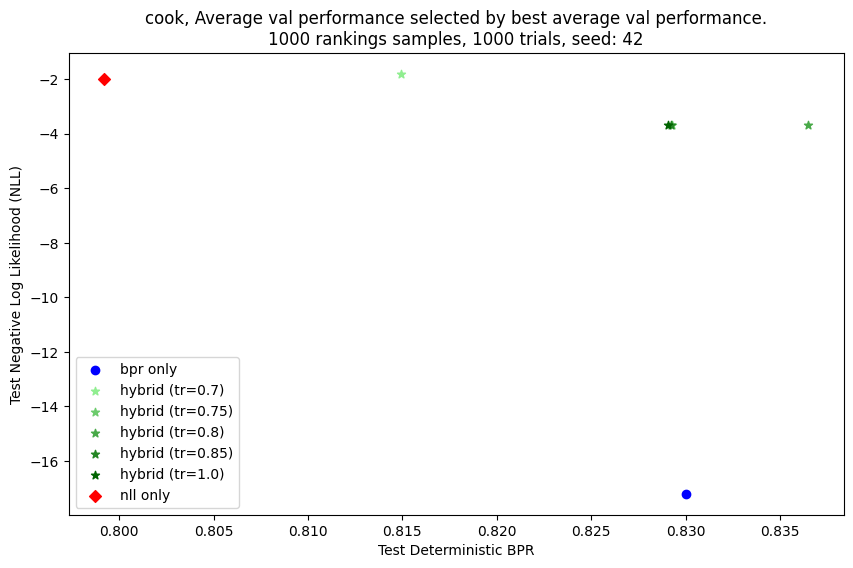

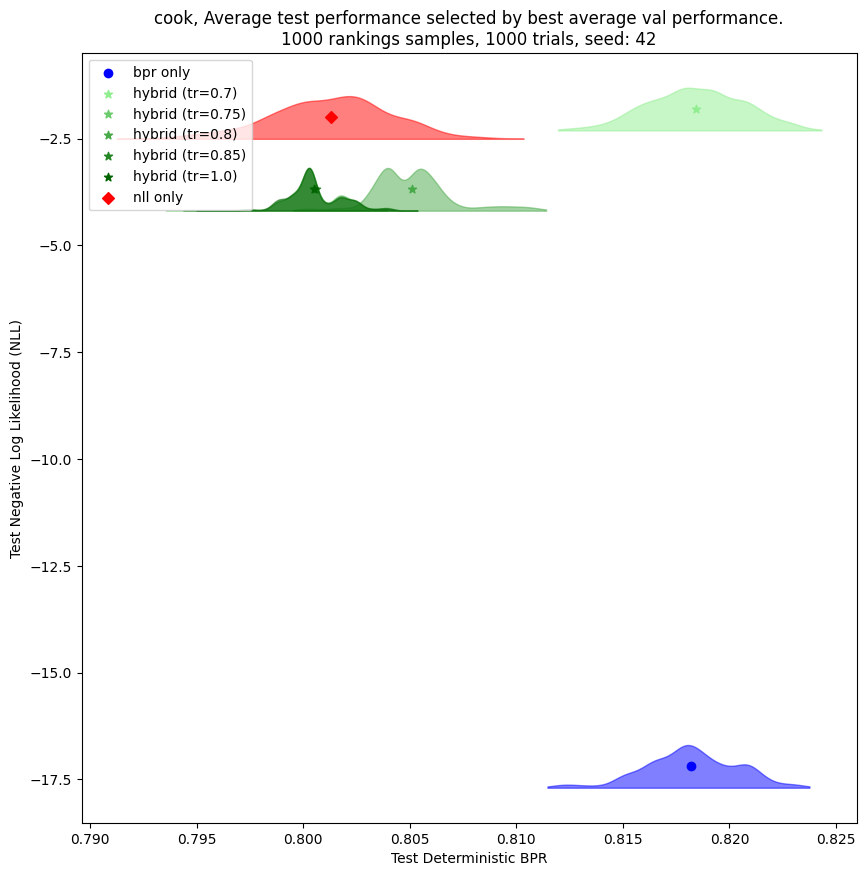

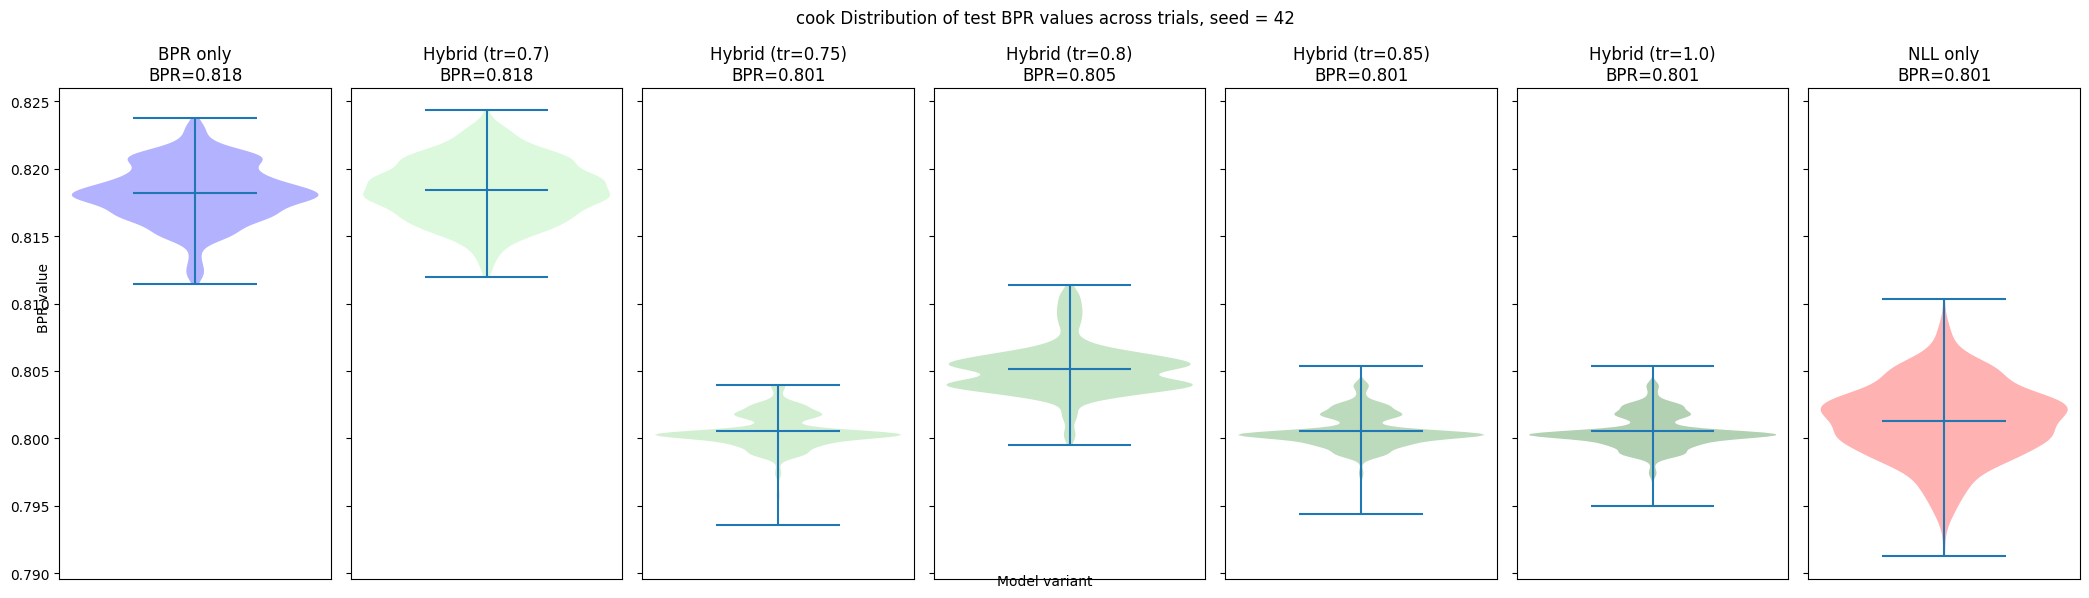

Processing experiment 0 of 189
Processing experiment 5 of 189
Processing experiment 10 of 189
Processing experiment 15 of 189
Processing experiment 20 of 189
Processing experiment 25 of 189
Processing experiment 30 of 189
Processing experiment 35 of 189
Processing experiment 40 of 189
Processing experiment 45 of 189
Processing experiment 50 of 189
Processing experiment 55 of 189
Processing experiment 60 of 189
Processing experiment 65 of 189
Processing experiment 70 of 189
Processing experiment 75 of 189
Processing experiment 80 of 189
Processing experiment 85 of 189
Processing experiment 90 of 189
Processing experiment 95 of 189
Processing experiment 100 of 189
Processing experiment 105 of 189
Processing experiment 110 of 189
Processing experiment 115 of 189
Processing experiment 120 of 189
Processing experiment 125 of 189
Processing experiment 130 of 189
Processing experiment 135 of 189
Processing experiment 140 of 189
Processing experiment 145 of 189
Processing experiment 150 of 189

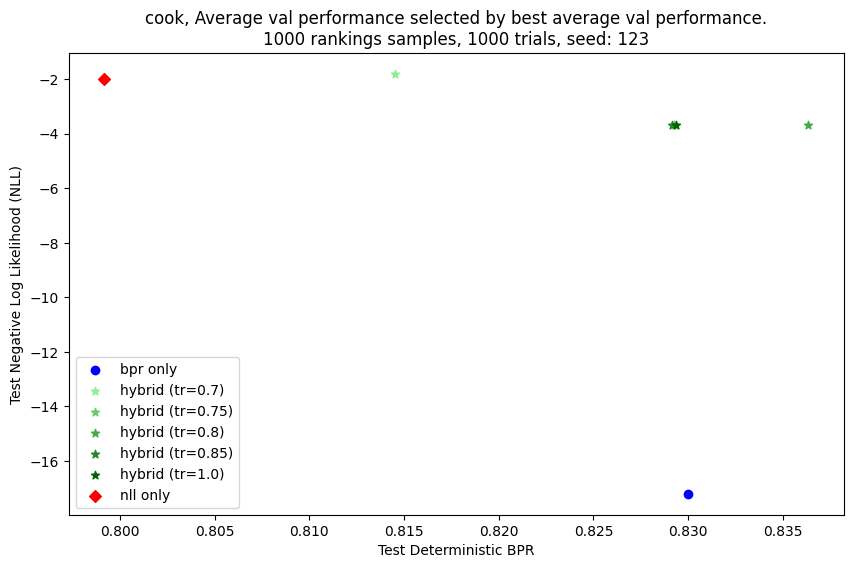

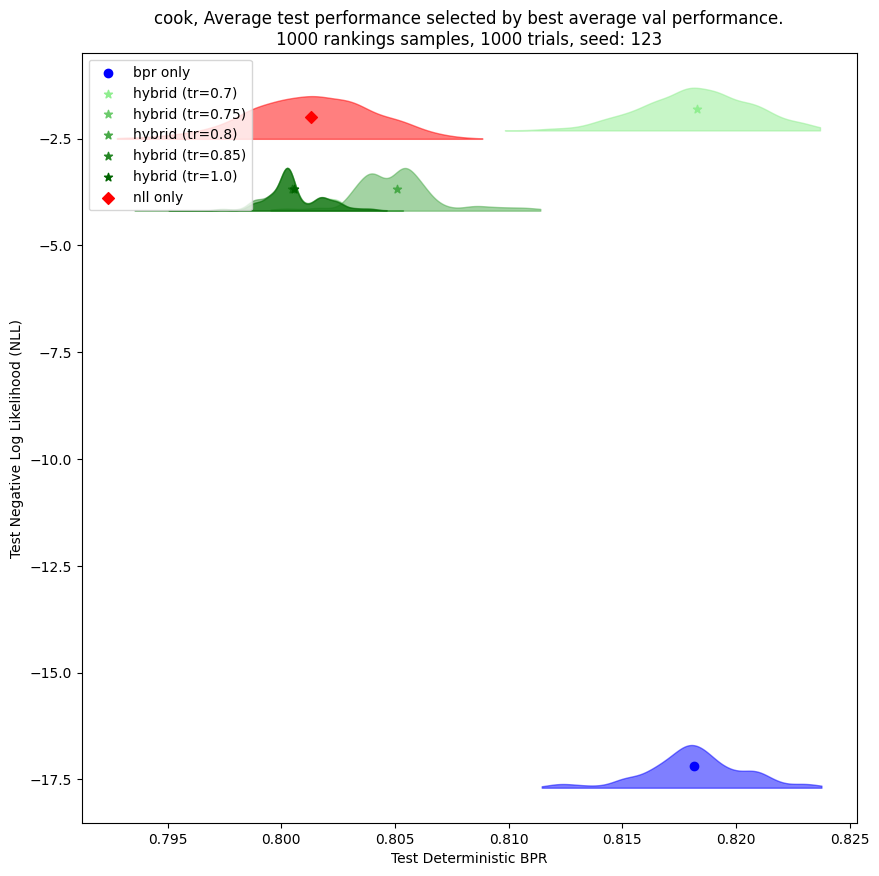

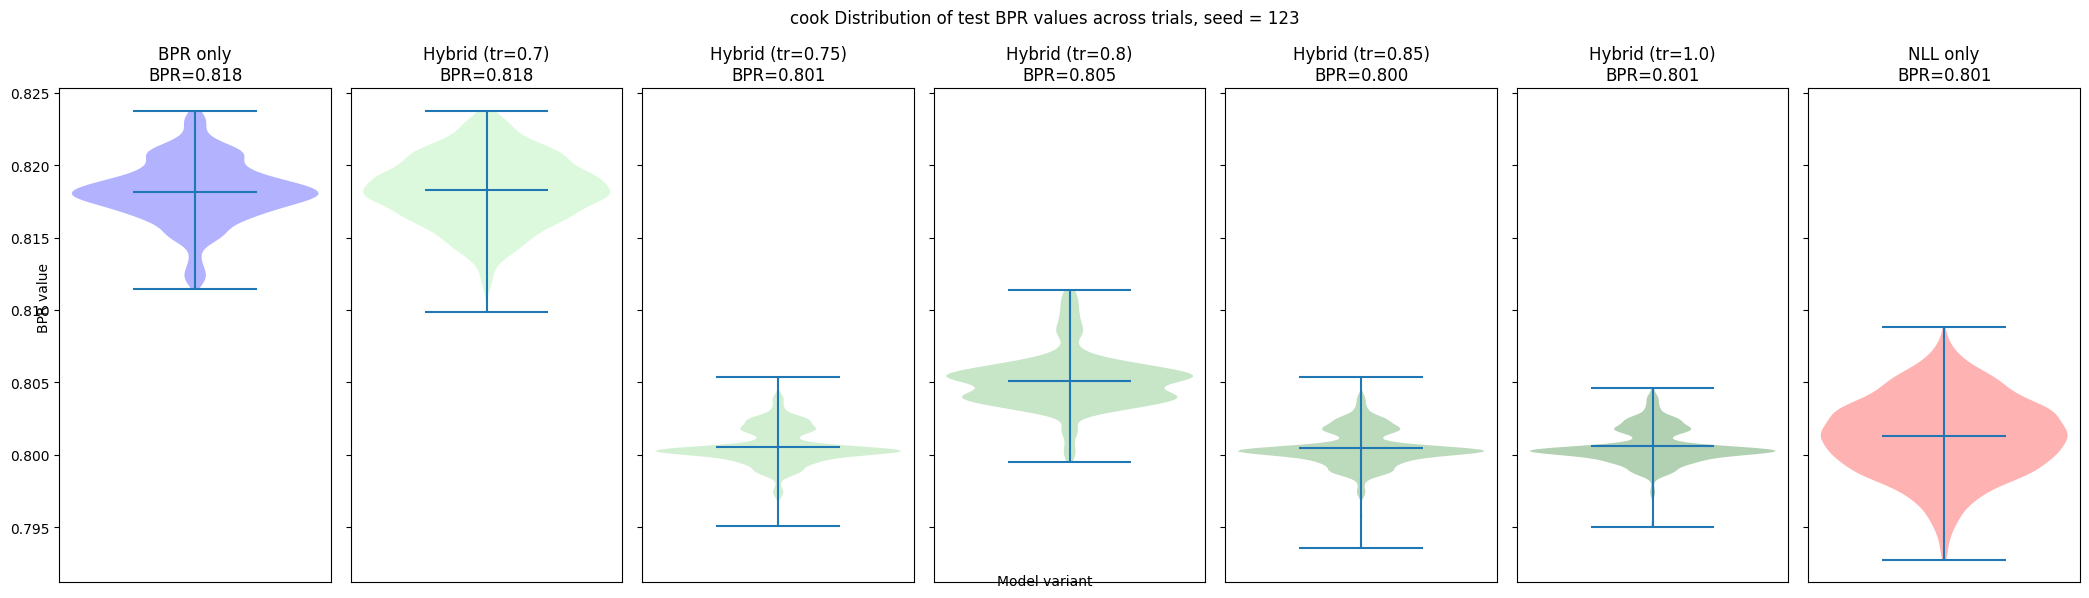

Processing experiment 0 of 189
Processing experiment 5 of 189
Processing experiment 10 of 189
Processing experiment 15 of 189
Processing experiment 20 of 189
Processing experiment 25 of 189
Processing experiment 30 of 189
Processing experiment 35 of 189
Processing experiment 40 of 189
Processing experiment 45 of 189
Processing experiment 50 of 189
Processing experiment 55 of 189
Processing experiment 60 of 189
Processing experiment 65 of 189
Processing experiment 70 of 189
Processing experiment 75 of 189
Processing experiment 80 of 189
Processing experiment 85 of 189
Processing experiment 90 of 189
Processing experiment 95 of 189
Processing experiment 100 of 189
Processing experiment 105 of 189
Processing experiment 110 of 189
Processing experiment 115 of 189
Processing experiment 120 of 189
Processing experiment 125 of 189
Processing experiment 130 of 189
Processing experiment 135 of 189
Processing experiment 140 of 189
Processing experiment 145 of 189
Processing experiment 150 of 189

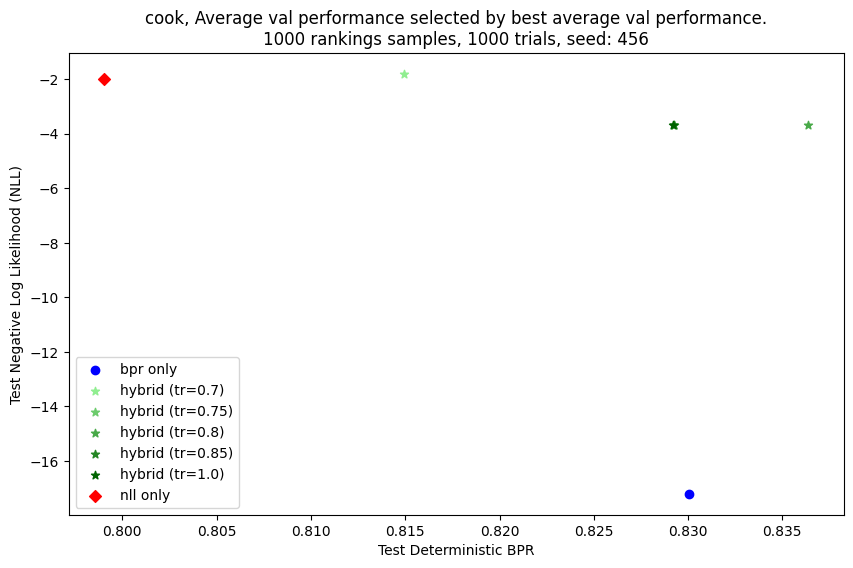

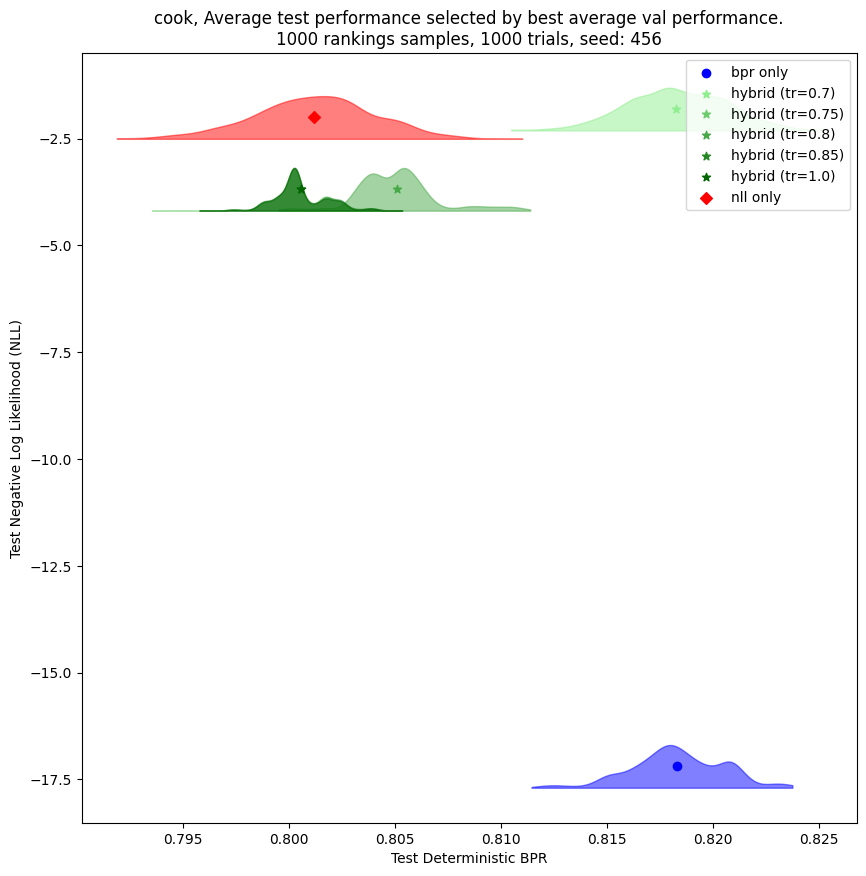

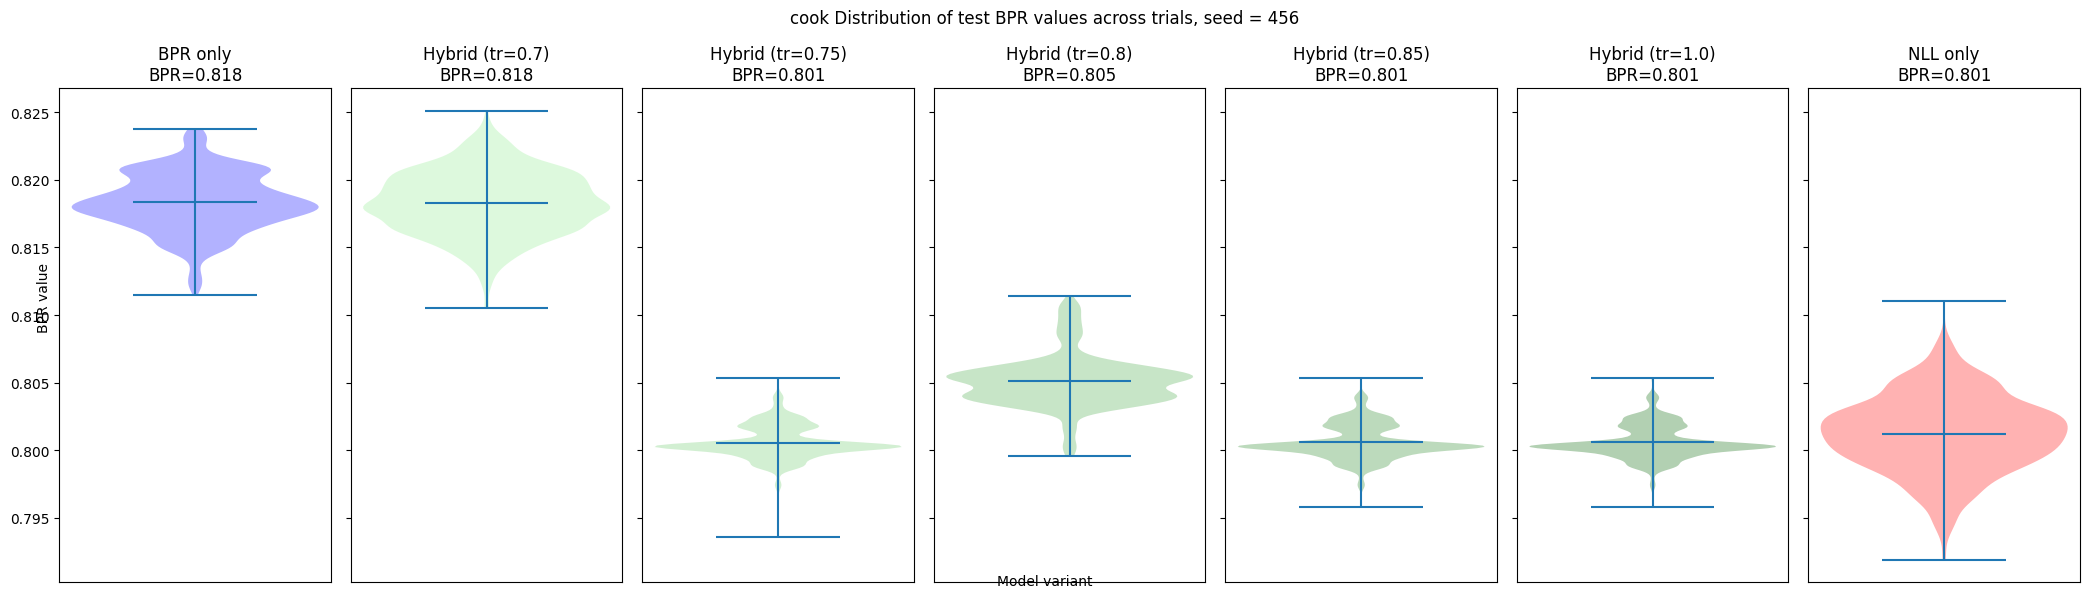

Num timesteps: 9
Num timesteps: 1
Num timesteps: 2
Processing experiment 0 of 114
Processing experiment 5 of 114
Processing experiment 10 of 114
Processing experiment 15 of 114
Processing experiment 20 of 114
Processing experiment 25 of 114
Processing experiment 30 of 114
Processing experiment 35 of 114
Processing experiment 40 of 114
Processing experiment 45 of 114
Processing experiment 50 of 114
Processing experiment 55 of 114
Processing experiment 60 of 114
Processing experiment 65 of 114
Processing experiment 70 of 114
Processing experiment 75 of 114
Processing experiment 80 of 114
Processing experiment 85 of 114
Processing experiment 90 of 114
Processing experiment 95 of 114
Processing experiment 100 of 114
Processing experiment 105 of 114
Processing experiment 110 of 114


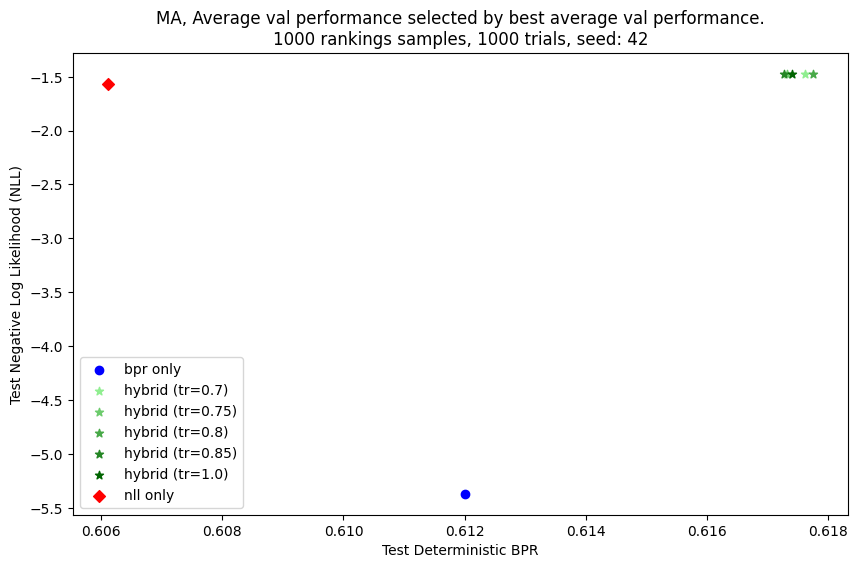

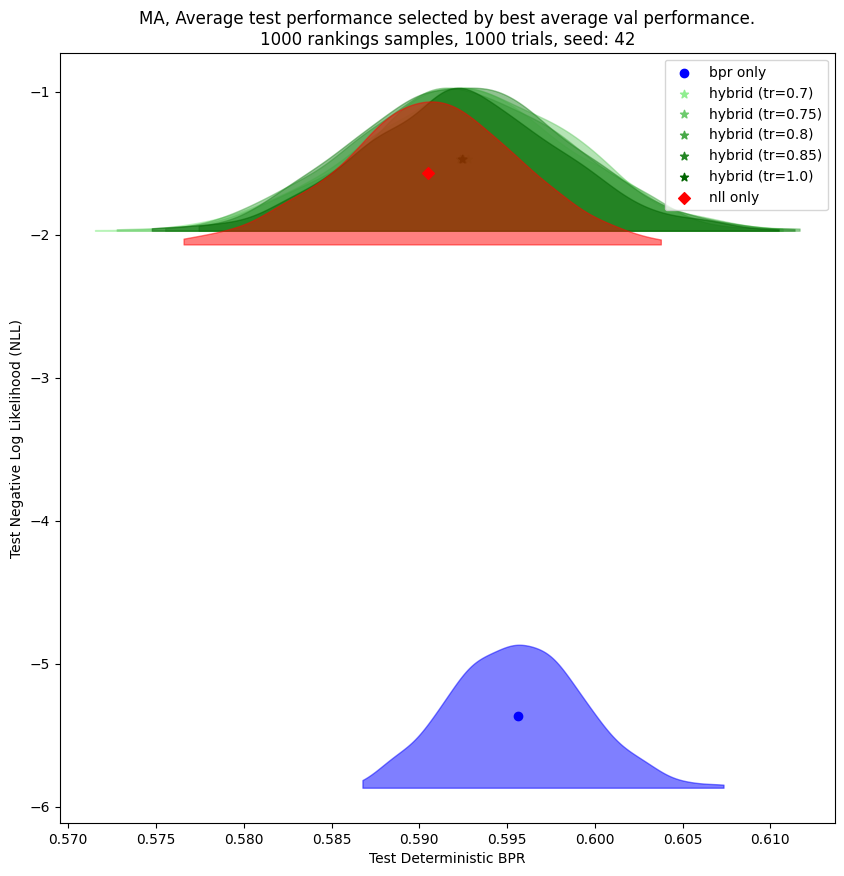

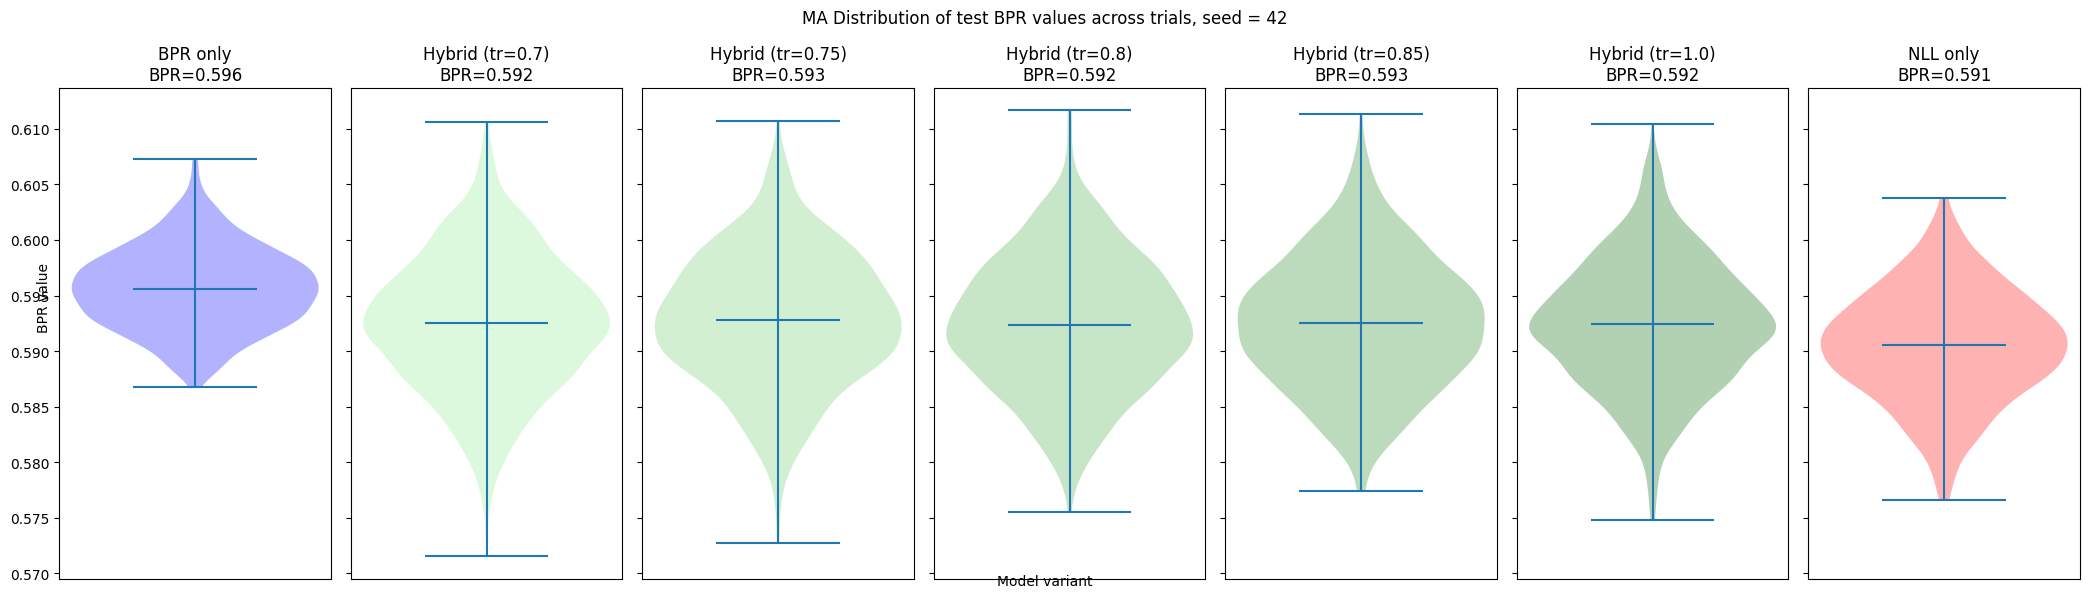

Processing experiment 0 of 114
Processing experiment 5 of 114
Processing experiment 10 of 114
Processing experiment 15 of 114
Processing experiment 20 of 114
Processing experiment 25 of 114
Processing experiment 30 of 114
Processing experiment 35 of 114
Processing experiment 40 of 114
Processing experiment 45 of 114
Processing experiment 50 of 114
Processing experiment 55 of 114
Processing experiment 60 of 114
Processing experiment 65 of 114
Processing experiment 70 of 114
Processing experiment 75 of 114
Processing experiment 80 of 114
Processing experiment 85 of 114
Processing experiment 90 of 114
Processing experiment 95 of 114
Processing experiment 100 of 114
Processing experiment 105 of 114
Processing experiment 110 of 114


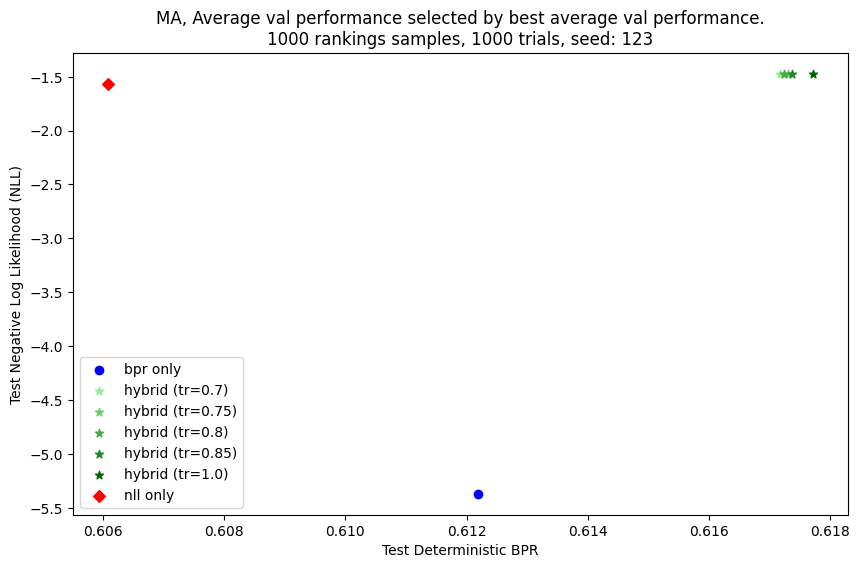

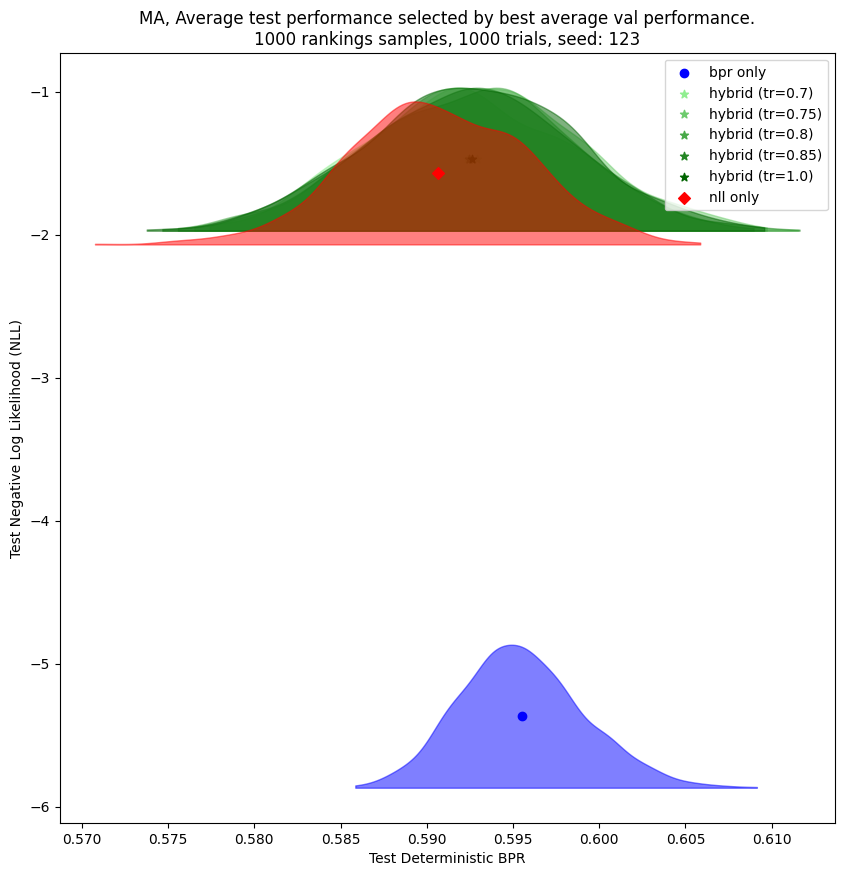

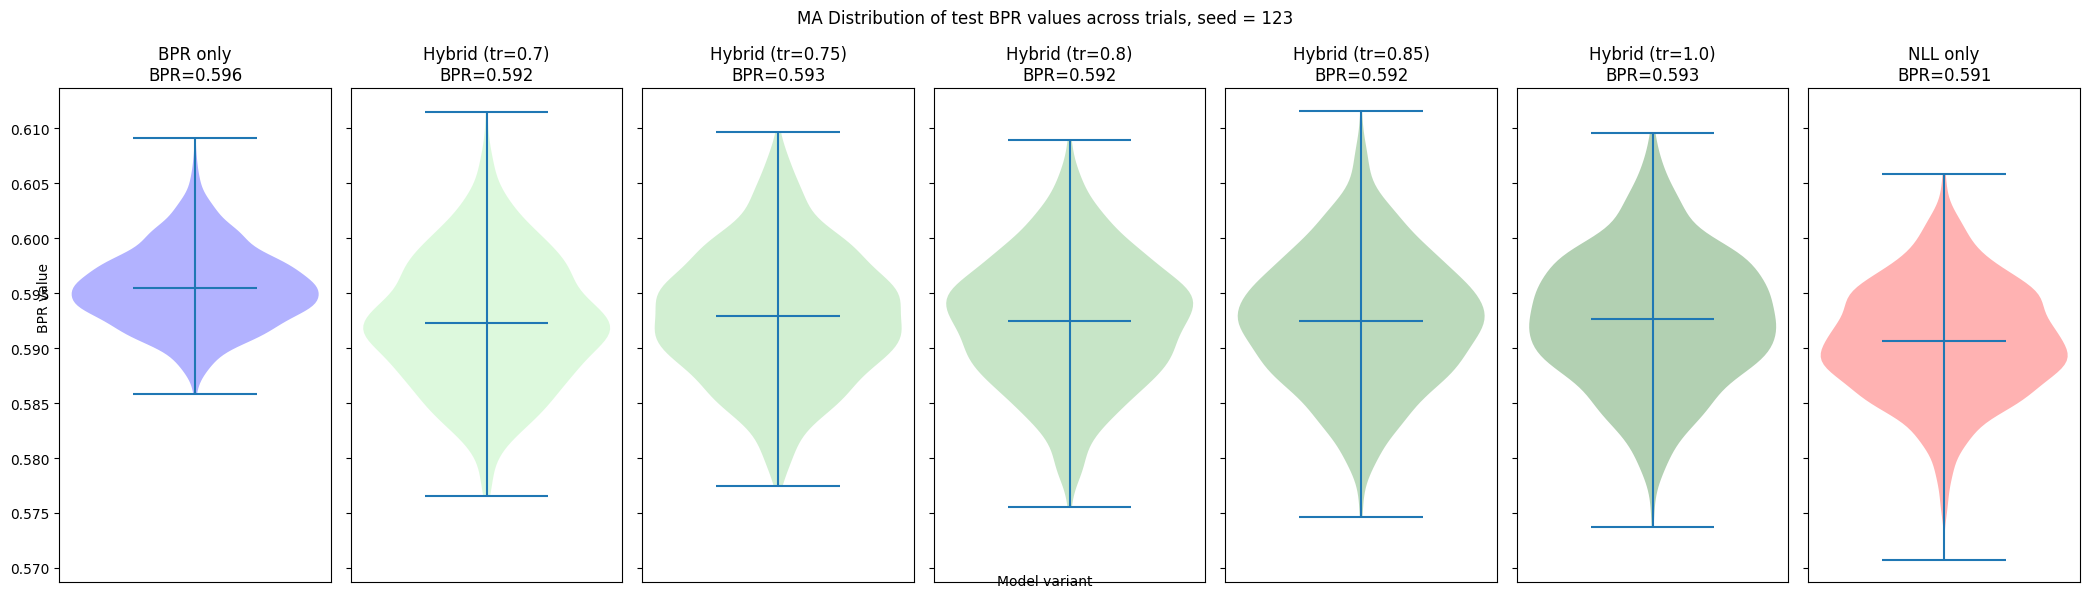

Processing experiment 0 of 114
Processing experiment 5 of 114
Processing experiment 10 of 114
Processing experiment 15 of 114
Processing experiment 20 of 114
Processing experiment 25 of 114
Processing experiment 30 of 114
Processing experiment 35 of 114
Processing experiment 40 of 114
Processing experiment 45 of 114
Processing experiment 50 of 114
Processing experiment 55 of 114
Processing experiment 60 of 114
Processing experiment 65 of 114
Processing experiment 70 of 114
Processing experiment 75 of 114
Processing experiment 80 of 114
Processing experiment 85 of 114
Processing experiment 90 of 114
Processing experiment 95 of 114
Processing experiment 100 of 114
Processing experiment 105 of 114
Processing experiment 110 of 114


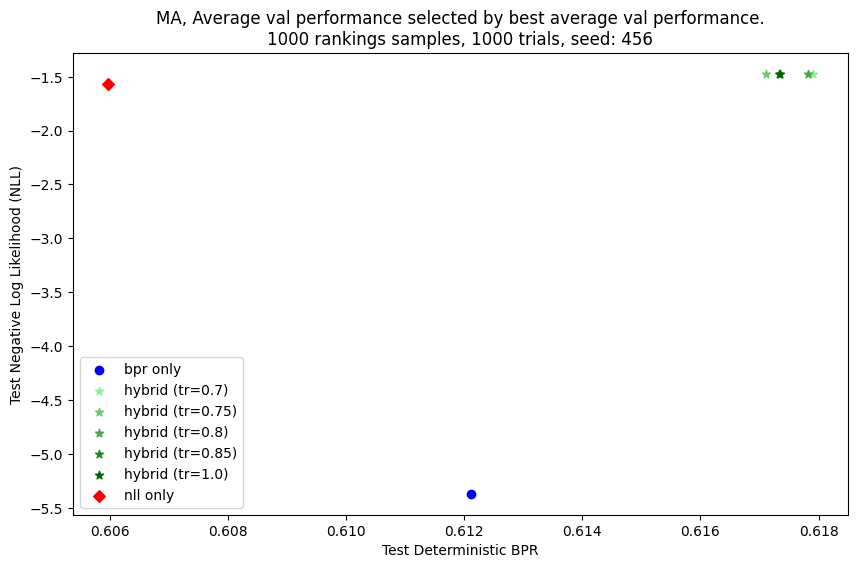

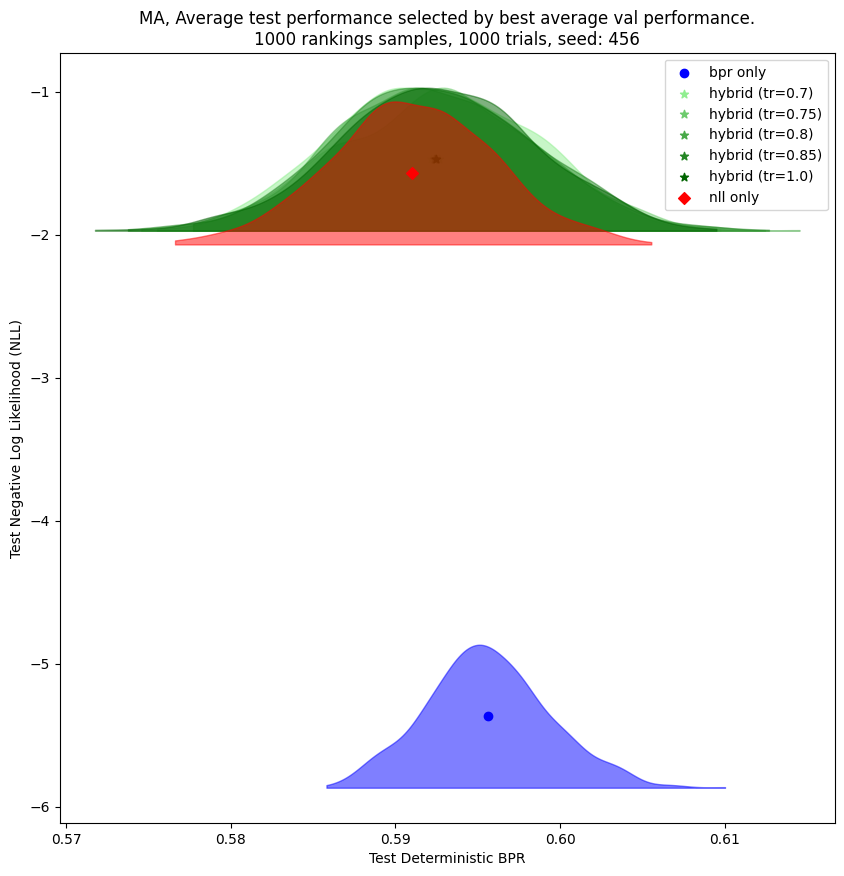

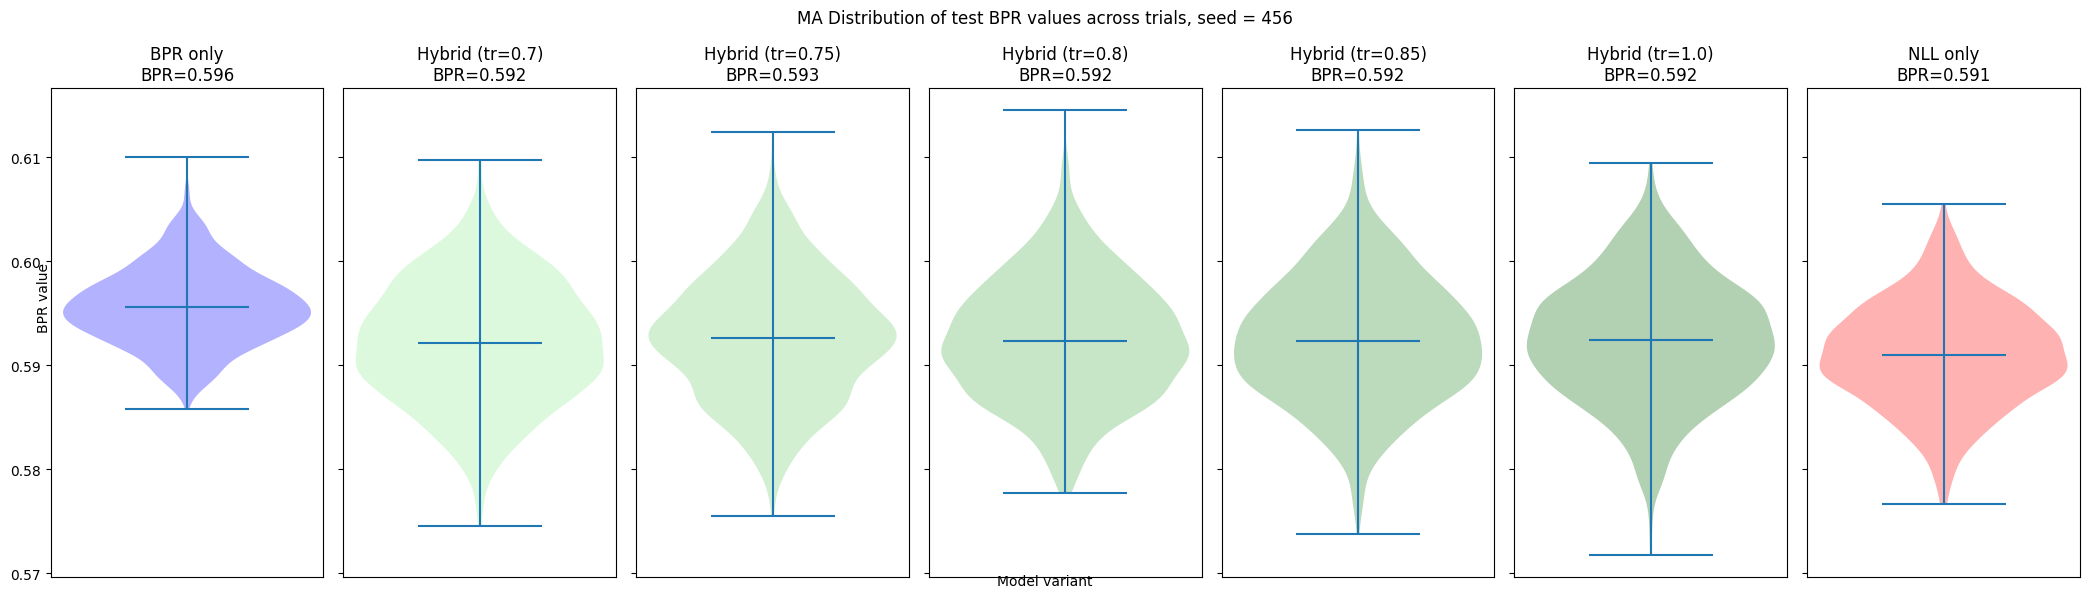

In [8]:

for location in ['cook', 'MA']:
    dirs = {'MA': ('/cluster/tufts/hugheslab/datasets/NSF_OD/cleaned/long/MA', '/cluster/tufts/hugheslab/kheuto01/opioid_hpc_test_long_big/MA/'),
            'cook': ('/cluster/tufts/hugheslab/datasets/NSF_OD/cleaned/cook', '/cluster/tufts/hugheslab/kheuto01/opioid_hpc_test_long_big/cook/'),}
    data_dir, base_dir = dirs[location]
    K=100

    exp_dirs = glob.glob(os.path.join(base_dir, "K*"))

    device = 'cuda'
    #K=100
    data = load_data(data_dir,bird=False)

    # Move data to device
    train_data = tuple(x.to(device) for x in data['train'])
    val_data = tuple(x.to(device) for x in data['val'])
    test_data = tuple(x.to(device) for x in data['test'])

    # Run the experiment with different seeds
    seeds = [42, 123, 456]
    for seed in seeds:
        run_experiment(seed)

Processing experiment 0 of 54
Processing experiment 5 of 54
Processing experiment 10 of 54
Processing experiment 15 of 54
Processing experiment 20 of 54
Processing experiment 25 of 54
Processing experiment 30 of 54
Processing experiment 35 of 54
Processing experiment 40 of 54
Processing experiment 45 of 54
Processing experiment 50 of 54


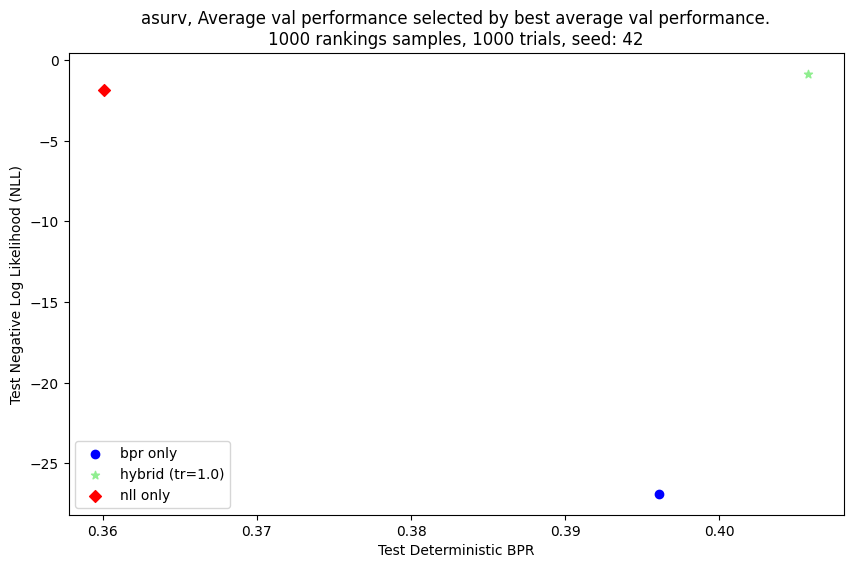

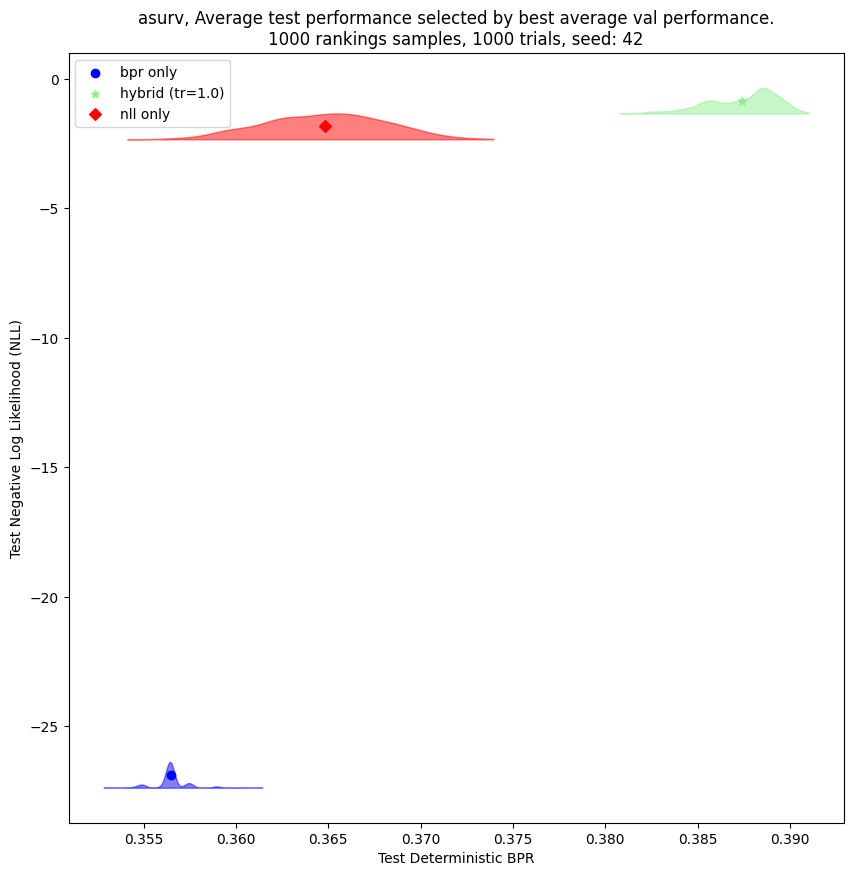

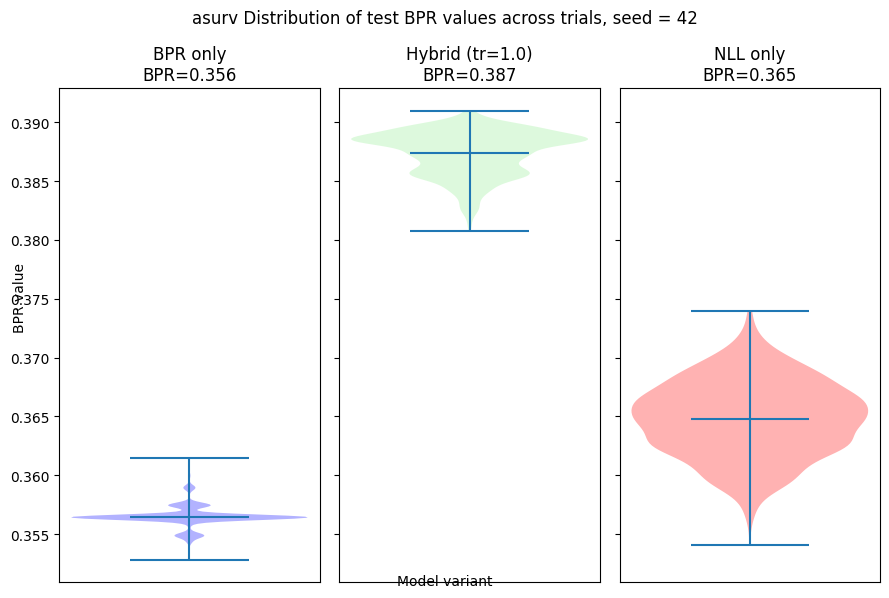

Processing experiment 0 of 54
Processing experiment 5 of 54
Processing experiment 10 of 54
Processing experiment 15 of 54
Processing experiment 20 of 54
Processing experiment 25 of 54
Processing experiment 30 of 54
Processing experiment 35 of 54
Processing experiment 40 of 54
Processing experiment 45 of 54
Processing experiment 50 of 54


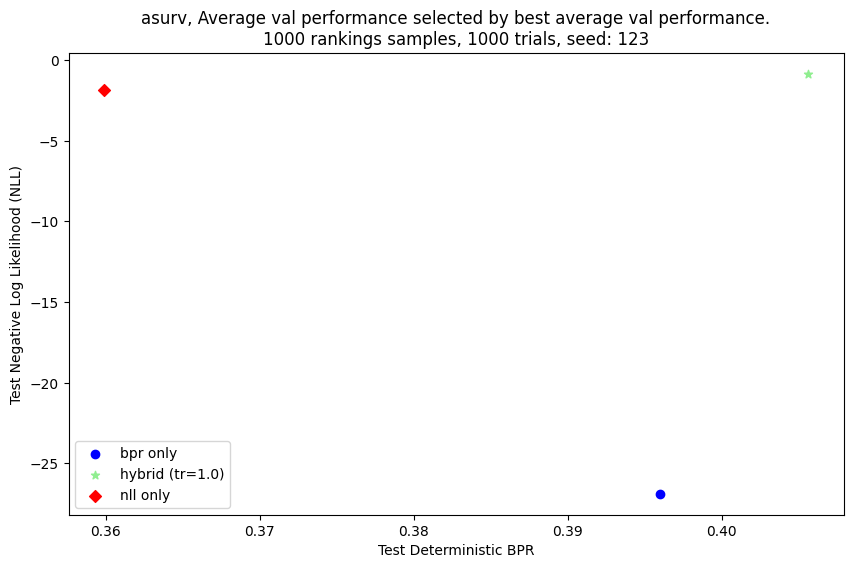

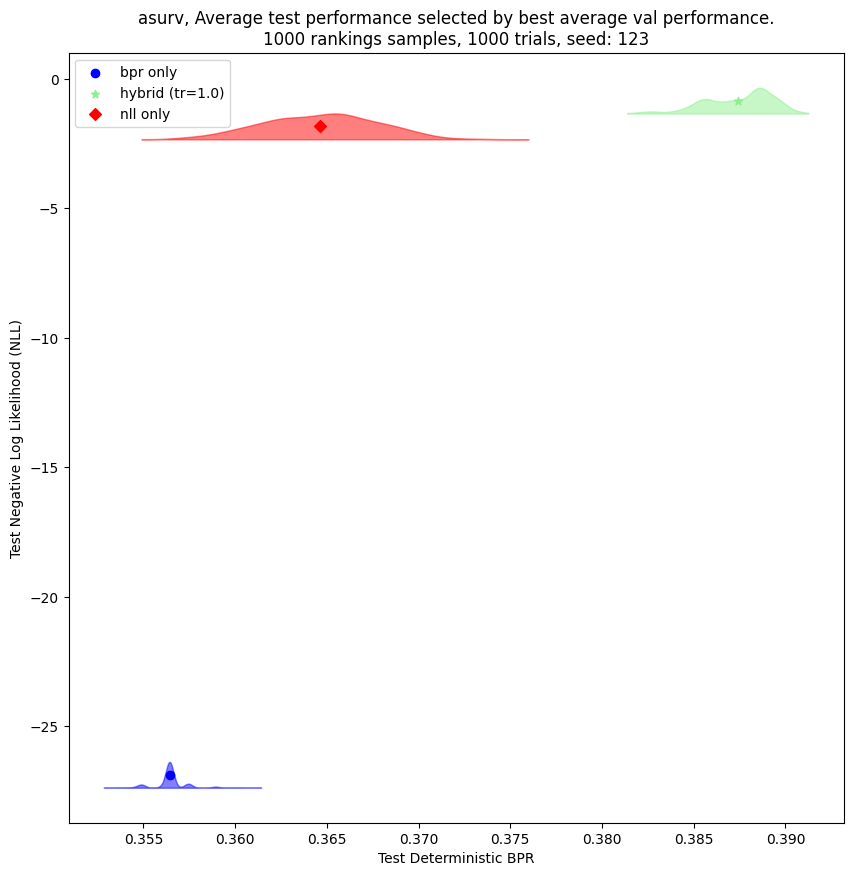

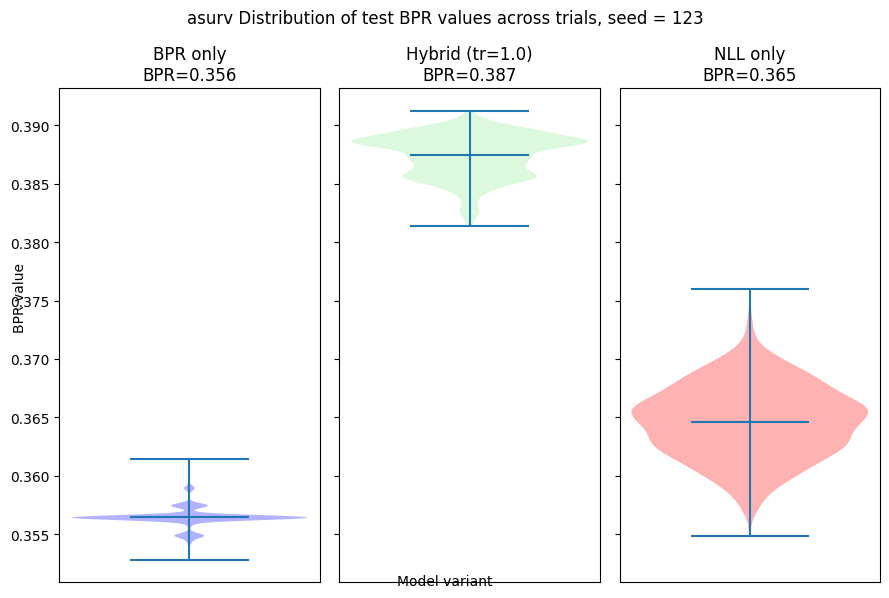

Processing experiment 0 of 54
Processing experiment 5 of 54
Processing experiment 10 of 54
Processing experiment 15 of 54
Processing experiment 20 of 54
Processing experiment 25 of 54
Processing experiment 30 of 54
Processing experiment 35 of 54
Processing experiment 40 of 54
Processing experiment 45 of 54
Processing experiment 50 of 54


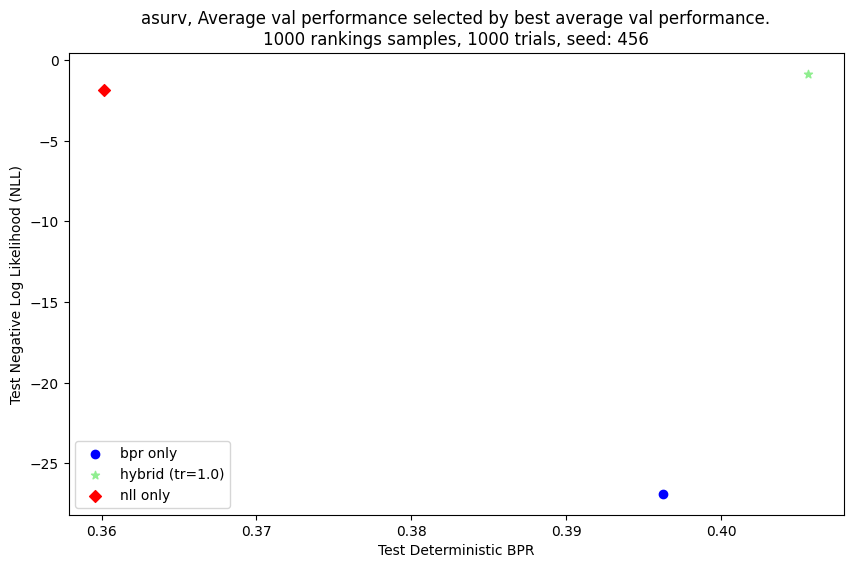

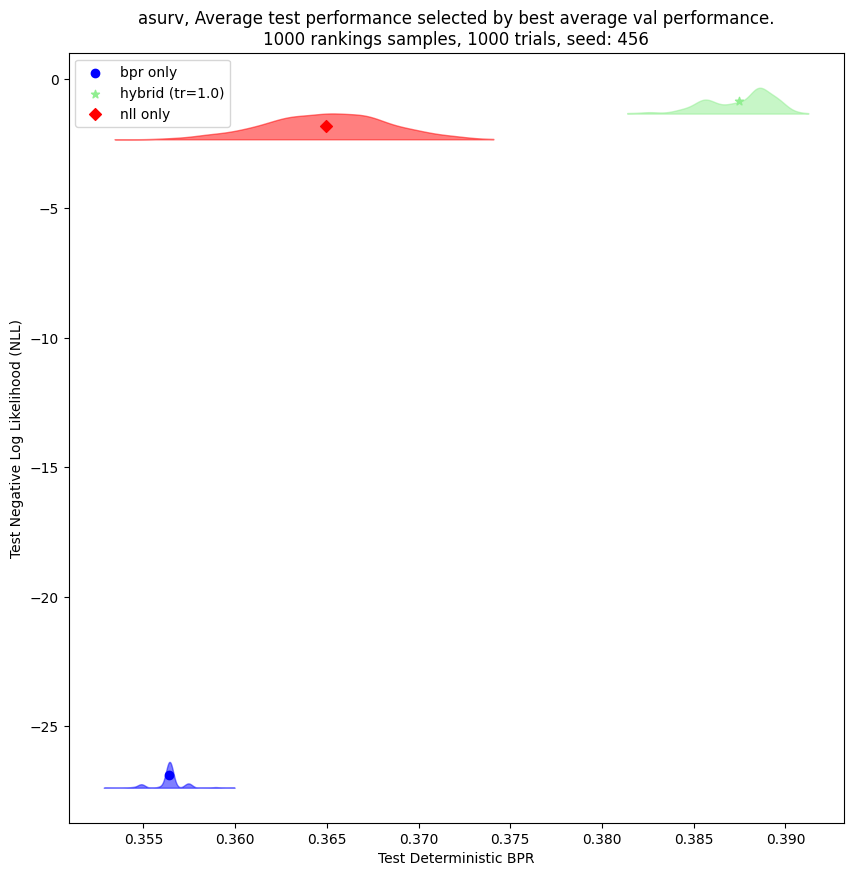

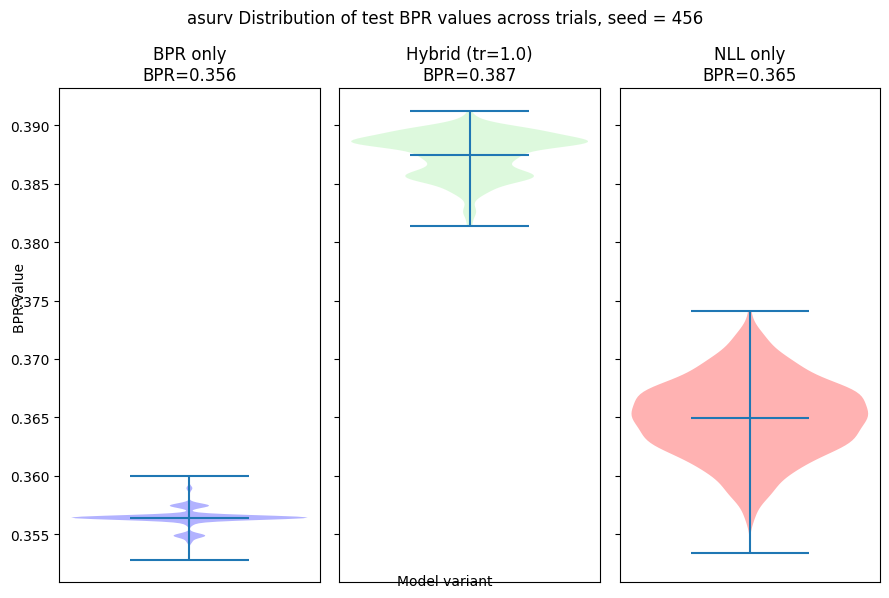

Processing experiment 0 of 54
Processing experiment 5 of 54
Processing experiment 10 of 54
Processing experiment 15 of 54
Processing experiment 20 of 54
Processing experiment 25 of 54
Processing experiment 30 of 54
Processing experiment 35 of 54
Processing experiment 40 of 54
Processing experiment 45 of 54
Processing experiment 50 of 54


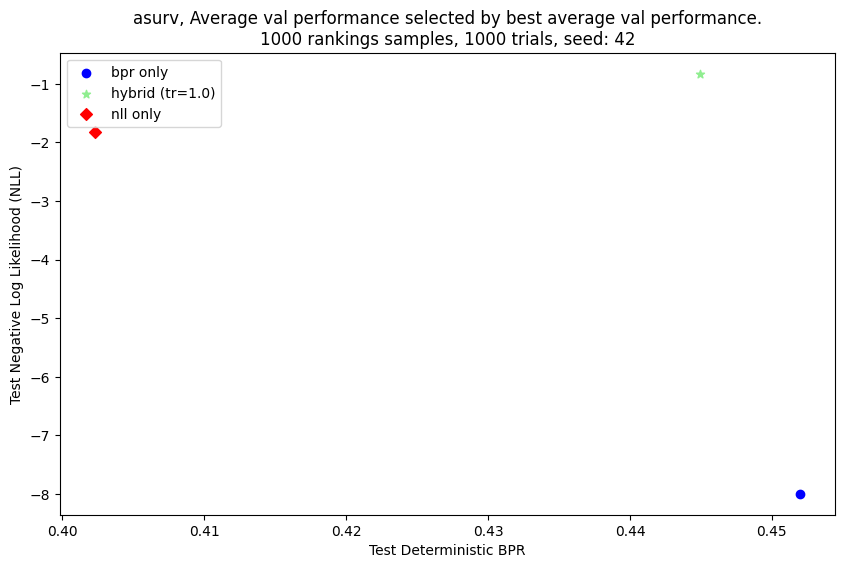

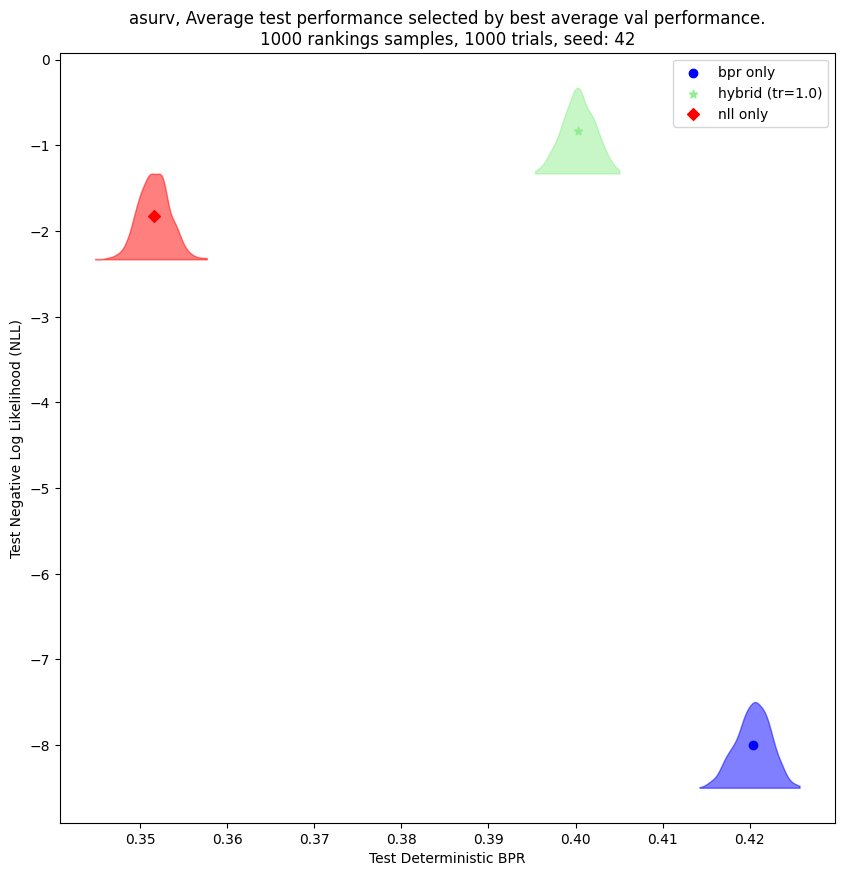

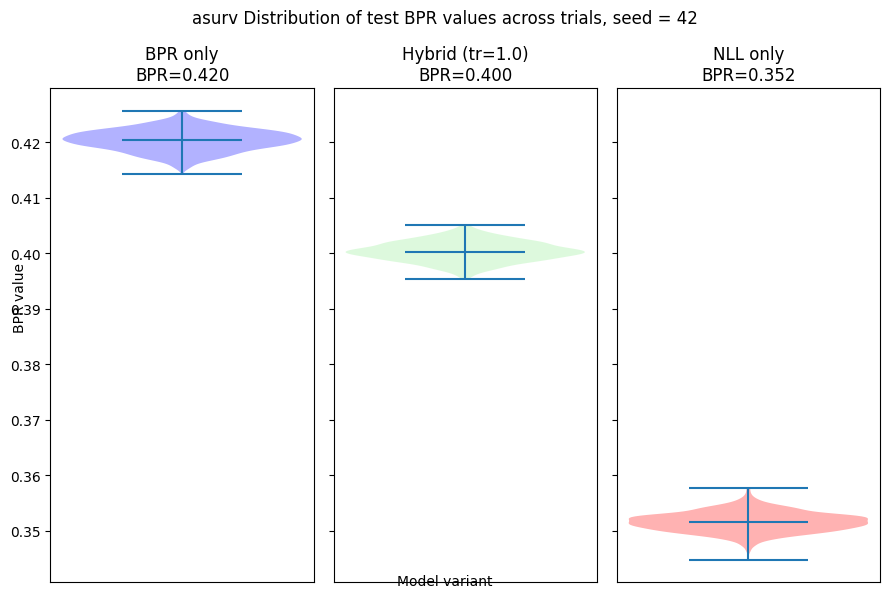

Processing experiment 0 of 54
Processing experiment 5 of 54
Processing experiment 10 of 54
Processing experiment 15 of 54
Processing experiment 20 of 54
Processing experiment 25 of 54
Processing experiment 30 of 54
Processing experiment 35 of 54
Processing experiment 40 of 54
Processing experiment 45 of 54
Processing experiment 50 of 54


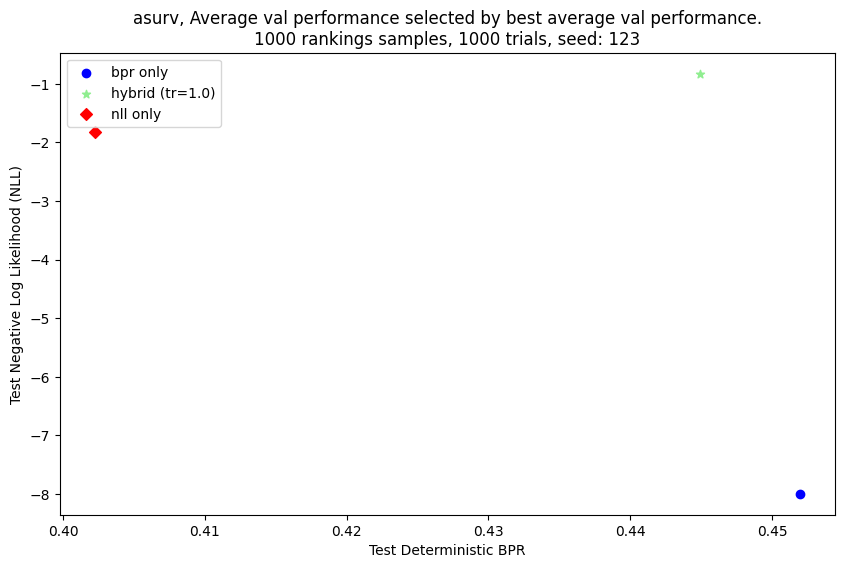

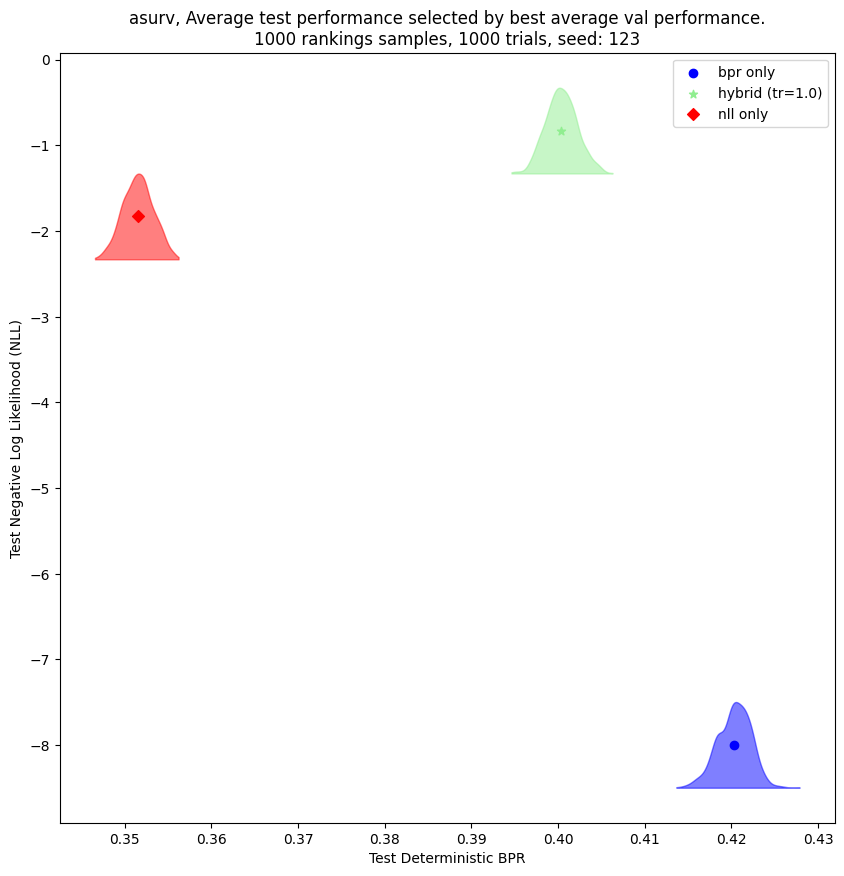

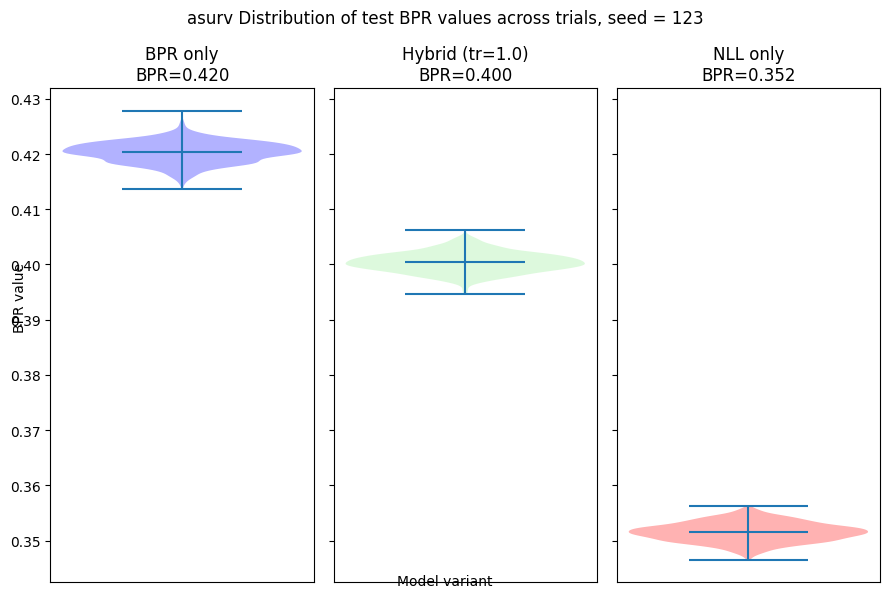

Processing experiment 0 of 54
Processing experiment 5 of 54
Processing experiment 10 of 54
Processing experiment 15 of 54
Processing experiment 20 of 54
Processing experiment 25 of 54
Processing experiment 30 of 54
Processing experiment 35 of 54
Processing experiment 40 of 54
Processing experiment 45 of 54
Processing experiment 50 of 54


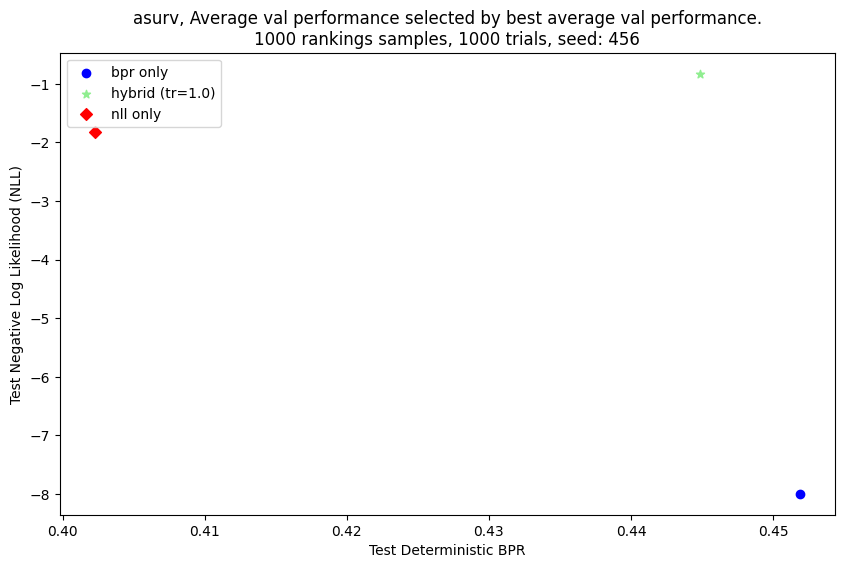

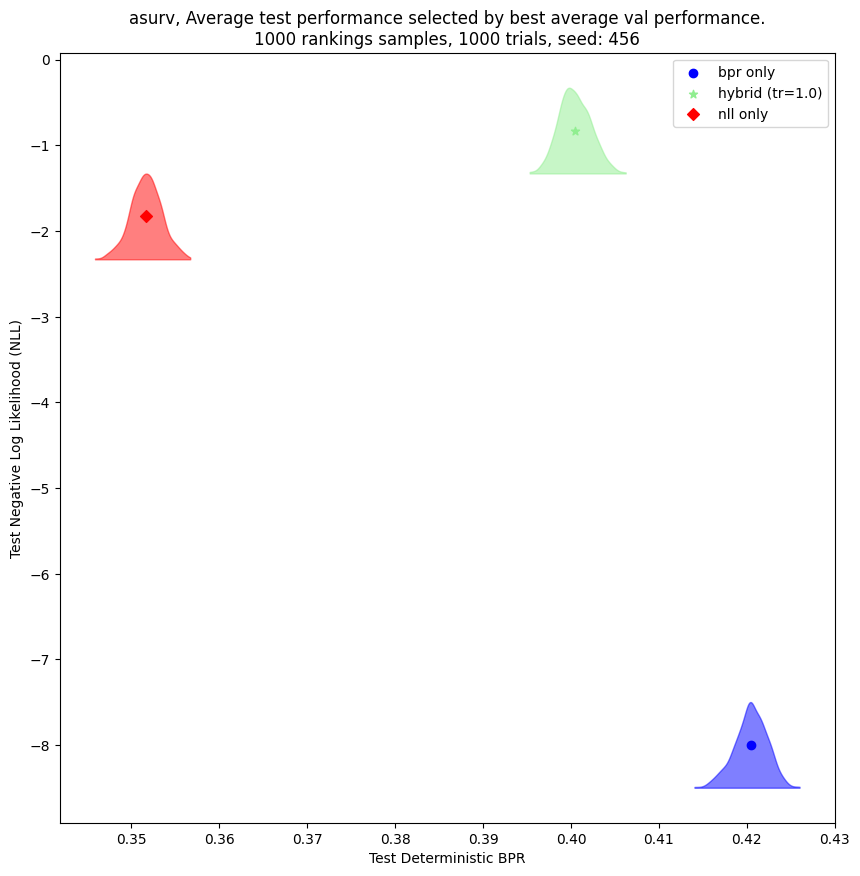

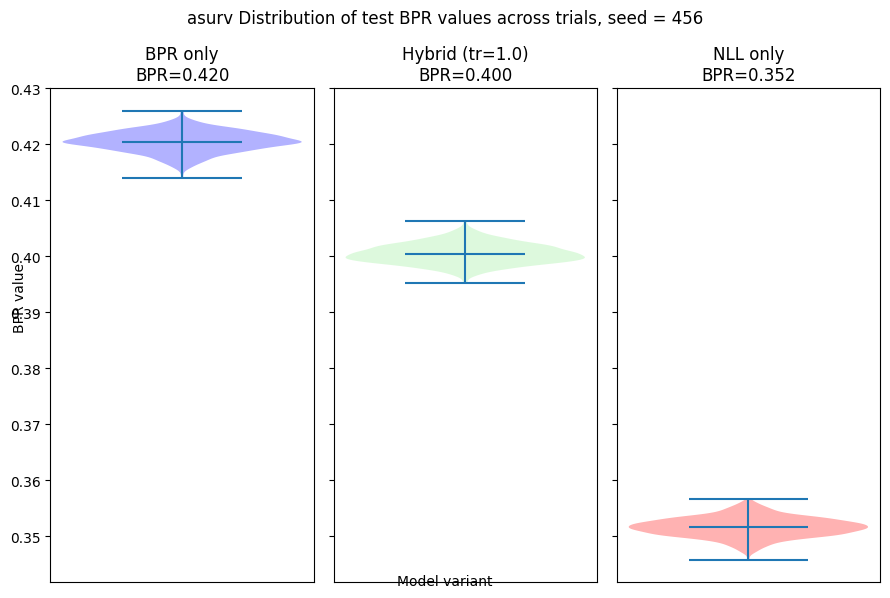

Processing experiment 0 of 38
Processing experiment 5 of 38
Processing experiment 10 of 38
Processing experiment 15 of 38
Processing experiment 20 of 38
Processing experiment 25 of 38
Processing experiment 30 of 38
Processing experiment 35 of 38


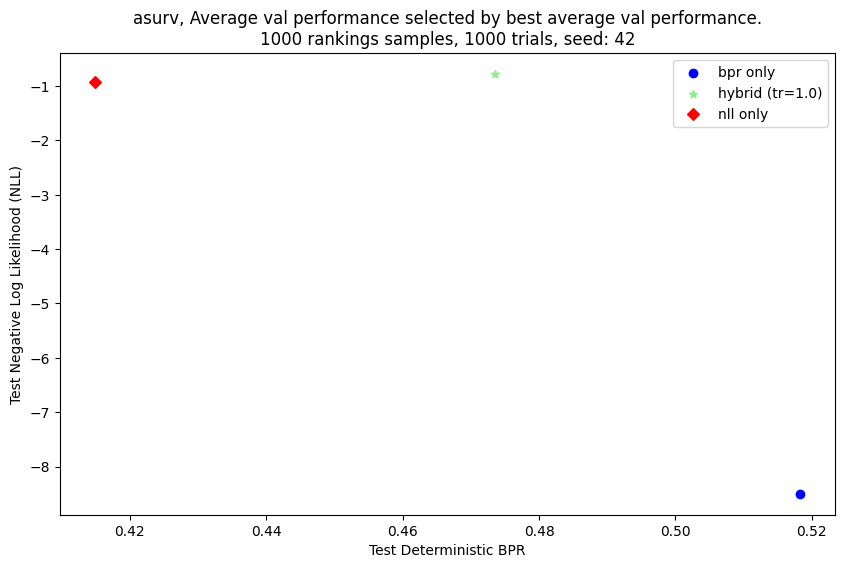

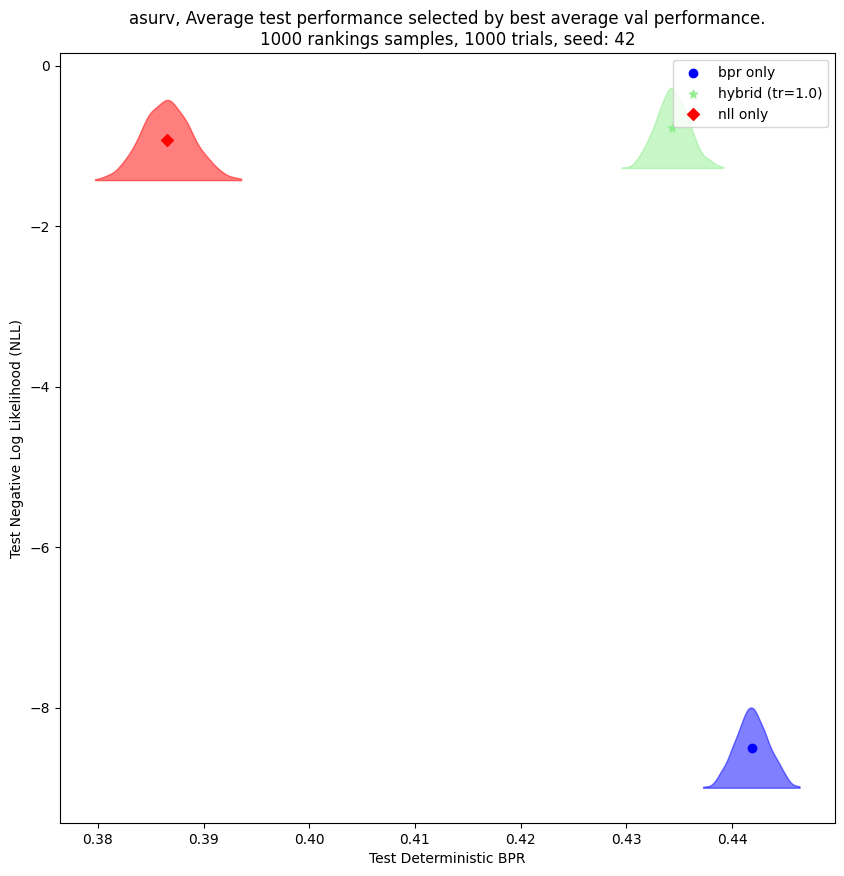

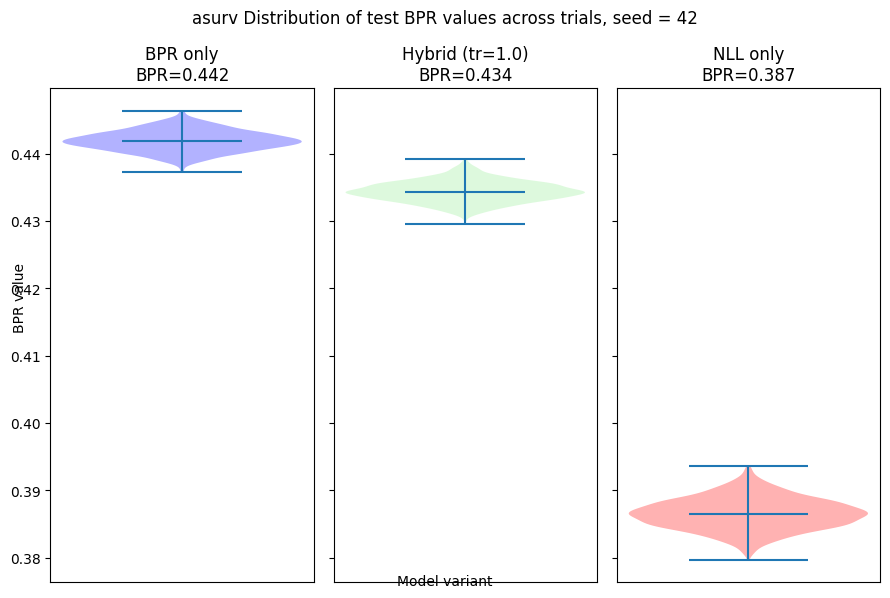

Processing experiment 0 of 38
Processing experiment 5 of 38
Processing experiment 10 of 38
Processing experiment 15 of 38
Processing experiment 20 of 38
Processing experiment 25 of 38
Processing experiment 30 of 38
Processing experiment 35 of 38


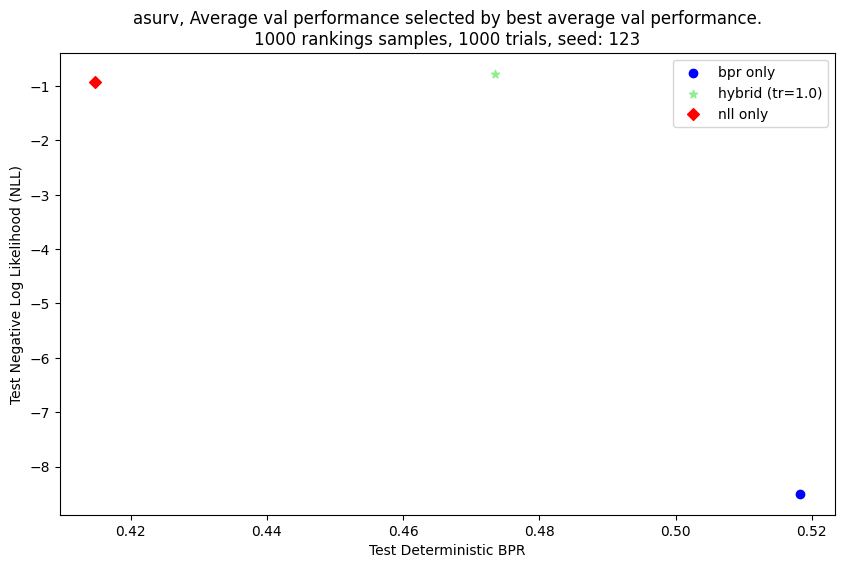

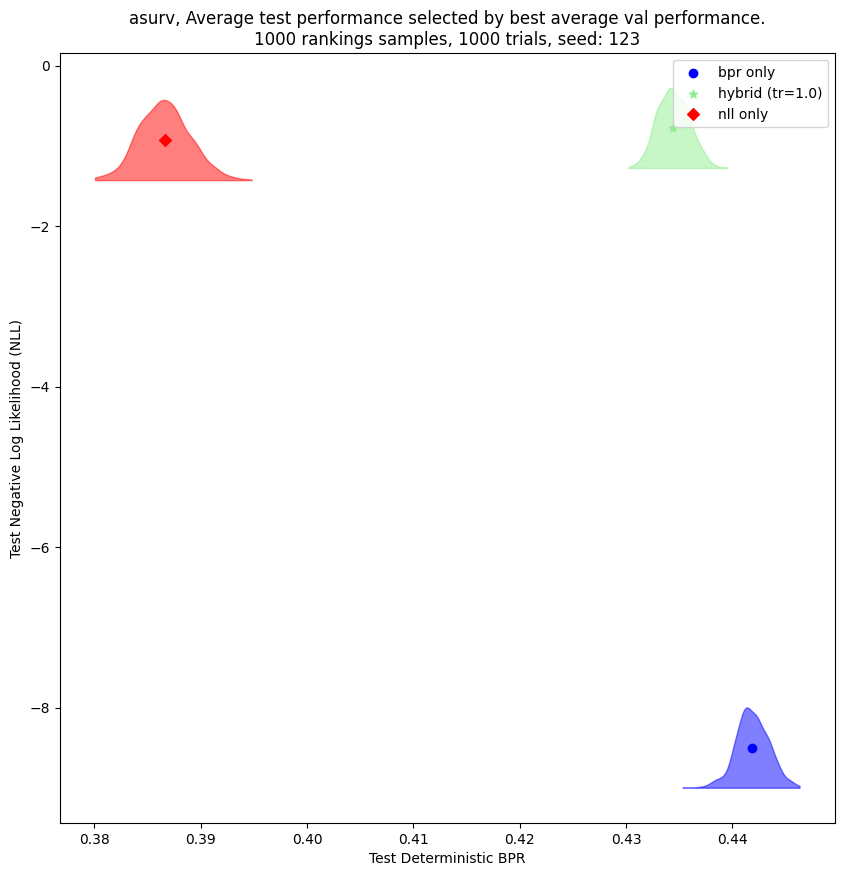

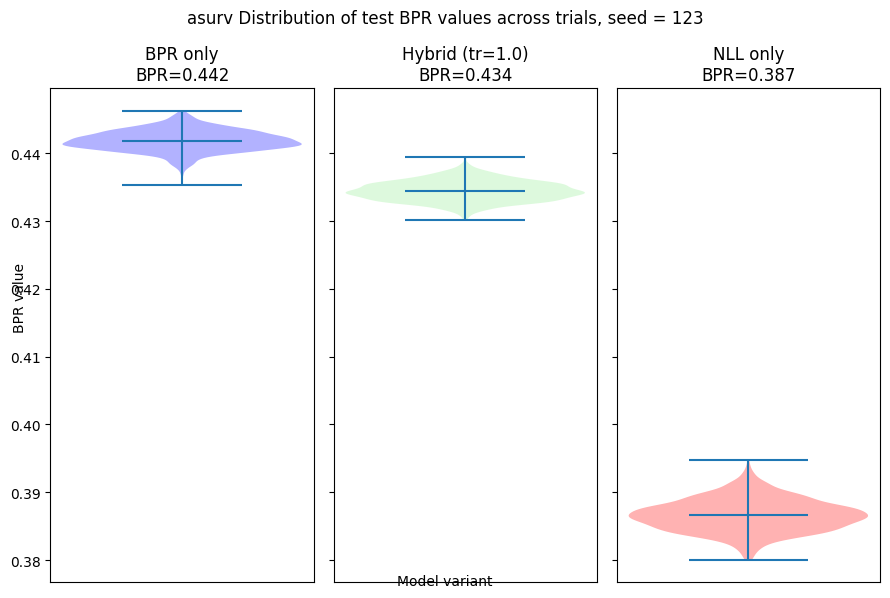

Processing experiment 0 of 38
Processing experiment 5 of 38
Processing experiment 10 of 38
Processing experiment 15 of 38
Processing experiment 20 of 38
Processing experiment 25 of 38
Processing experiment 30 of 38
Processing experiment 35 of 38


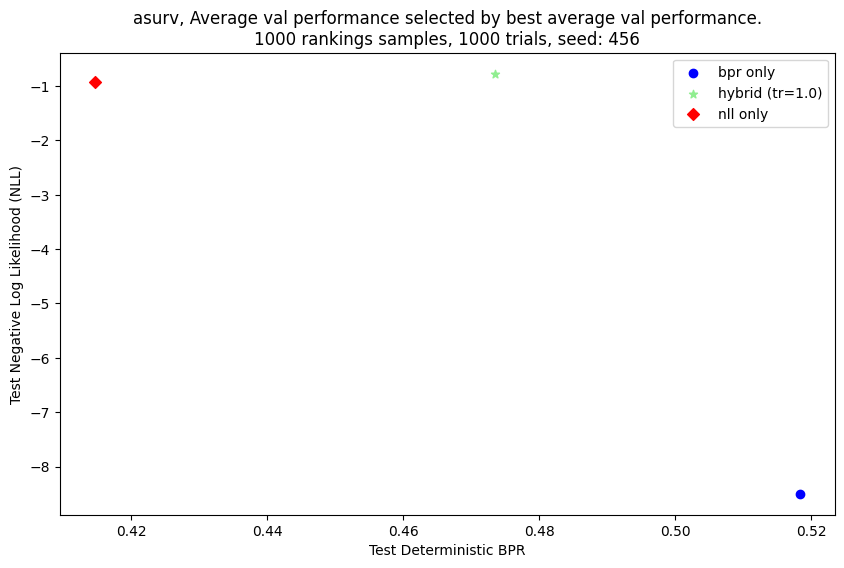

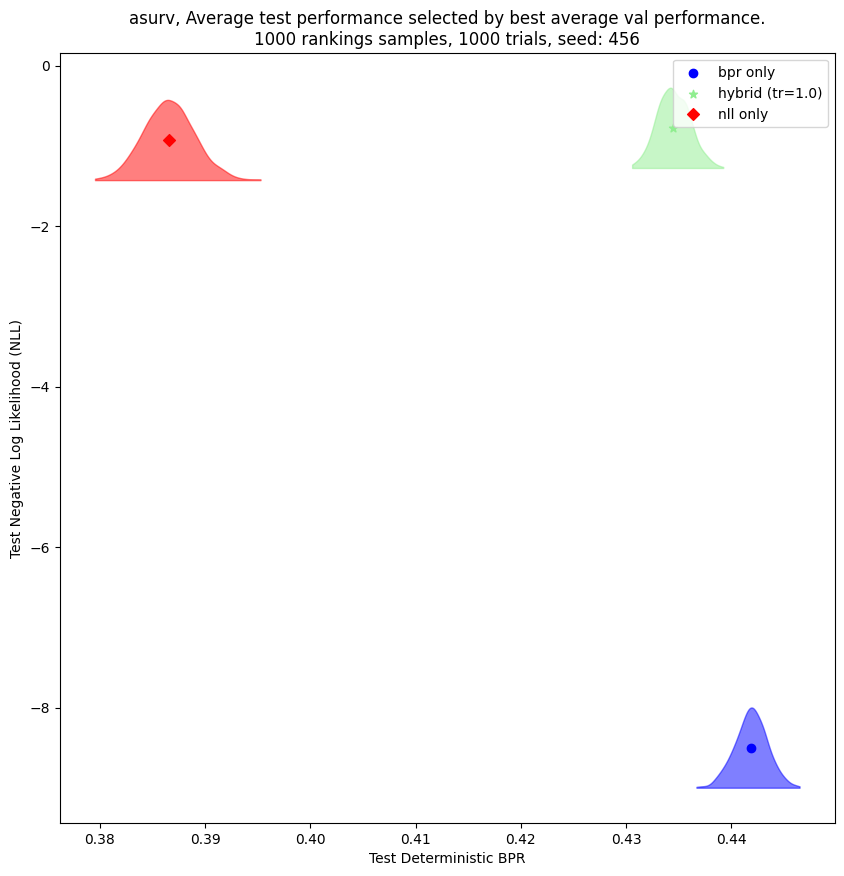

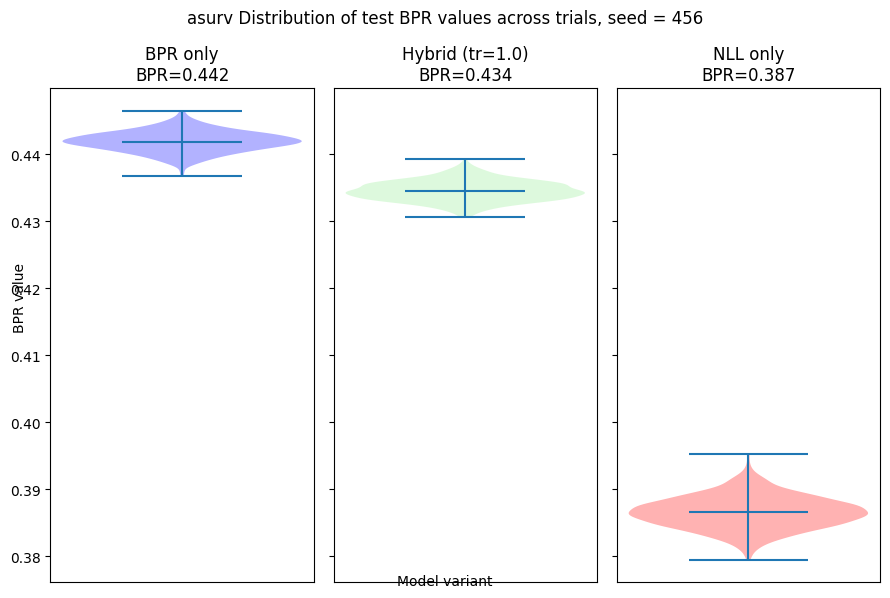

In [40]:
for K in [25, 50, 75]:
    location ='asurv'
    data_dir = '/cluster/tufts/hugheslab/fmuenc01/code/prob_diff_topk/data_dir/asurv/2monthly_ctxtSize5_small/'
    base_dir = f'/cluster/tufts/hugheslab/fmuenc01/bird_zero_rand_K{K}_8000_bigFix/{location}'

    exp_dirs = glob.glob(os.path.join(base_dir, "K*"))

    device = 'cuda'

    data = load_data(data_dir,bird=True)

    # Move data to device
    val_data = tuple(x.to(device) for x in data['val'])
    test_data = tuple(x.to(device) for x in data['test'])


    num_ranking_samples = 1000
    num_trials = 1000
    # Run the experiment with different seeds
    seeds = [42, 123, 456]
    for seed in seeds:
        run_experiment(seed)


In [36]:
exp_dirs

[]

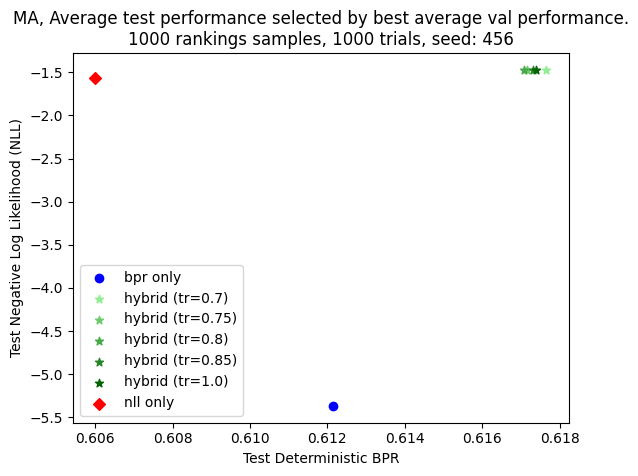

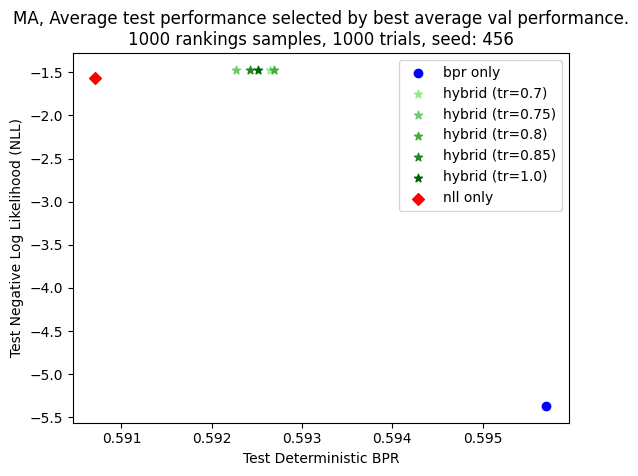

In [56]:
# Define colors and markers
colors = { (30, 0): 'blue', (30, 1): 'green', (0, 1): 'red' }
markers = { (30, 0): 'o', (30, 1): '*', (0, 1): 'D' }
labelslist = { (30, 0): 'bpr only', (30, 1): 'hybrid', (0, 1): 'nll only' }

# Generate shades of green for different thresholds
thresholds = sorted(results_df['tr'].dropna().unique())
shades_of_green = list(mcolors.LinearSegmentedColormap.from_list("", ["lightgreen", "darkgreen"])(np.linspace(0, 1, len(thresholds))))

# Plot data points
for bw, nw in [(30, 0), (30, 1), (0, 1)]:
    mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
    if bw == 30 and nw == 0:
        idx = results_df[mask]['avg_val_bpr'].idxmax()
        plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
        sns.violinplot(data=trial_val_bprs[idx], inner=None, color=colors[(bw, nw)], cut=2, bw=0.2)
    elif bw == 30 and nw == 1:
        for i, tr in enumerate(thresholds):
            tr_mask = mask & (results_df['tr'] == tr)
            idx = results_df[tr_mask]['avg_val_bpr'].idxmax()
            plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                        color=shades_of_green[i], marker=markers[(bw, nw)], label=f"{labelslist[(bw, nw)]} (tr={tr})")
            sns.violinplot(data=trial_val_bprs[idx], inner=None, color=shades_of_green[i], cut=2, bw=0.2)
    elif bw == 0 and nw == 1:
        idx = results_df[mask]['avg_val_bpr'].idxmax()
        plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
        sns.violinplot(data=trial_val_bprs[idx], inner=None, color=colors[(bw, nw)], cut=2, bw=0.2)

# Set labels and legend
plt.title(f'{location}, Average test performance selected by best average val performance.\n'
          f'{num_ranking_samples} rankings samples, {num_trials} trials, seed: {seed}')
plt.xlabel('Test Deterministic BPR')
plt.ylabel('Test Negative Log Likelihood (NLL)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
plt.legend(by_label.values(), by_label.keys())
plt.savefig(f'results_seed_{seed}_val.png')
plt.show()

# Plot the test nll and bpr, but choose models based on the best val_det_bpr
for bw, nw in [(30, 0), (30, 1), (0, 1)]:
    mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
    if bw == 30 and nw == 0:
        idx = results_df[mask]['avg_val_bpr'].idxmax()
        plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
        sns.violinplot(data=trial_val_bprs[idx], inner=None, color=colors[(bw, nw)], cut=2, bw=0.2)
    elif bw == 30 and nw == 1:
        for i, tr in enumerate(thresholds):
            tr_mask = mask & (results_df['tr'] == tr)
            idx = results_df[tr_mask]['avg_val_bpr'].idxmax()
            plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                        color=shades_of_green[i], marker=markers[(bw, nw)], label=f"{labelslist[(bw, nw)]} (tr={tr})")
            sns.violinplot(data=trial_val_bprs[idx], inner=None, color=shades_of_green[i], cut=2, bw=0.2)
    elif bw == 0 and nw == 1:
        idx = results_df[mask]['avg_val_bpr'].idxmax()
        plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
        sns.violinplot(data=trial_val_bprs[idx], inner=None, color=colors[(bw, nw)], cut=2, bw=0.2)

# Set labels and legend
plt.title(f'{location}, Average test performance selected by best average val performance.\n'
          f'{num_ranking_samples} rankings samples, {num_trials} trials, seed: {seed}')
plt.xlabel('Test Deterministic BPR')
plt.ylabel('Test Negative Log Likelihood (NLL)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
plt.legend(by_label.values(), by_label.keys())
plt.savefig(f'results_seed_{seed}_test.png')
plt.show()

NameError: name 'loc' is not defined

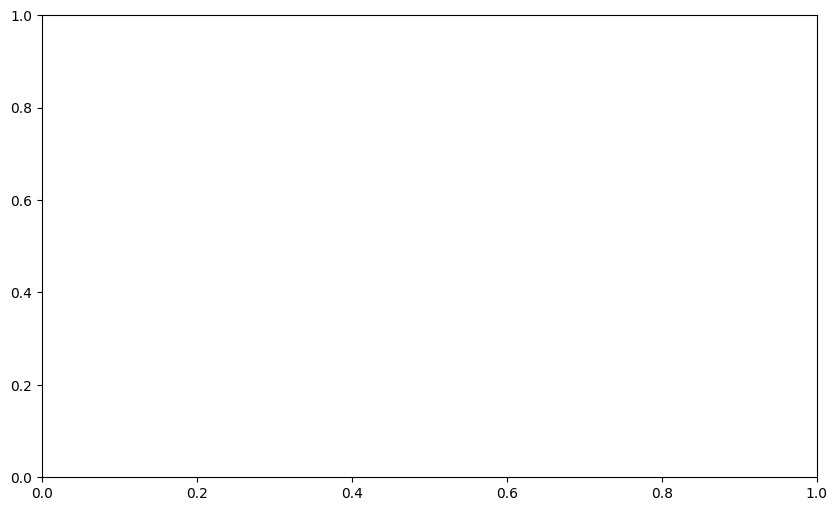

In [54]:
import seaborn as sns

# Prepare data for plotting
val_bprs = [np.mean(trial) for trial in trial_val_bprs]
test_bprs = [np.mean(trial) for trial in trial_test_bprs]

# Create a dataframe for seaborn
plot_data = pd.DataFrame({
    'avg_val_bpr': val_bprs,
    'avg_test_bpr': test_bprs,
    'val_nll': val_nlls,
    'test_nll': test_nlls,
    'bw': results_df['bw'],
    'nw': results_df['nw'],
    'tr': results_df['tr'],
    'trial_val_bprs': trial_val_bprs,
    'trial_test_bprs': trial_test_bprs
})

# Define colors and markers
colors = { (30, 0): 'blue', (30, 1): 'green', (0, 1): 'red' }
markers = { (30, 0): 'o', (30, 1): '*', (0, 1): 'D' }
labelslist = { (30, 0): 'bpr only', (30, 1): 'hybrid', (0, 1): 'nll only' }

# Generate shades of green for different thresholds
thresholds = sorted(plot_data['tr'].dropna().unique())
shades_of_green = list(mcolors.LinearSegmentedColormap.from_list("", ["lightgreen", "darkgreen"])(np.linspace(0, 1, len(thresholds))))

# Plot data points
plt.figure(figsize=(10, 6))
for bw, nw in [(30, 0), (30, 1), (0, 1)]:
    mask = (plot_data['bw'] == bw) & (plot_data['nw'] == nw)
    if bw == 30 and nw == 0:
        idx = plot_data[mask]['avg_val_bpr'].idxmax()
        sns.violinplot(data=plot_data.loc[mask, 'trial_val_bprs'].explode(), inner=None, color=colors[(bw, nw)], cut=2, bw=0.2)
        #plt.scatter(plot_data.loc[idx, 'avg_val_bpr'], -plot_data.loc[idx, 'test_nll'], color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
    elif bw == 30 and nw == 1:
        for i, tr in enumerate(thresholds):
            tr_mask = mask & (plot_data['tr'] == tr)
            idx = plot_data[tr_mask]['avg_val_bpr'].idxmax()
            sns.violinplot(data=plot_data.loc[tr_mask, 'trial_val_bprs'].explode(), inner=None, color=shades_of_green[i], cut=2, bw=0.2)
            #plt.scatter(plot_data.loc[idx, 'avg_val_bpr'], -plot_data.loc[idx, 'test_nll'], color=shades_of_green[i], marker=markers[(bw, nw)], label=f"{labelslist[(bw, nw)]} (tr={tr})")
    elif bw == 0 and nw == 1:
        idx = plot_data[mask]['avg_val_bpr'].idxmax()
        sns.violinplot(data=plot_data.loc[mask, 'trial_val_bprs'].explode(), inner=None, color=colors[(bw, nw)], cut=2, bw=0.2)
        #plt.scatter(plot_data.loc[idx, 'avg_val_bpr'], -plot_data.loc[idx, 'test_nll'], color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])

# Set labels and legend
plt.title(f'{location}, Val performance selected by val performance')
plt.xlabel('Test Deterministic BPR')
plt.ylabel('Test Negative Log Likelihood (NLL)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
plt.legend(by_label.values(), by_label.keys())
plt.show()

# Plot the test nll and bpr, but choose models based on the best val_det_bpr
plt.figure(figsize=(10, 6))
for bw, nw in [(30, 0), (30, 1), (0, 1)]:
    mask = (plot_data['bw'] == bw) & (plot_data['nw'] == nw)
    if bw == 30 and nw == 0:
        idx = plot_data[mask]['avg_val_bpr'].idxmax()
        sns.violinplot(data=plot_data.loc[mask, 'trial_test_bprs'].explode(), inner=None, color=colors[(bw, nw)], cut=2, bw=0.2)
        plt.scatter(plot_data.loc[idx, 'avg_test_bpr'], -plot_data.loc[idx, 'test_nll'], color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
    elif bw == 30 and nw == 1:
        for i, tr in enumerate(thresholds):
            tr_mask = mask & (plot_data['tr'] == tr)
            idx = plot_data[tr_mask]['avg_val_bpr'].idxmax()
            sns.violinplot(data=plot_data.loc[tr_mask, 'trial_test_bprs'].explode(), inner=None, color=shades_of_green[i], cut=2, bw=0.2)
            plt.scatter(plot_data.loc[idx, 'avg_test_bpr'], -plot_data.loc[idx, 'test_nll'], color=shades_of_green[i], marker=markers[(bw, nw)], label=f"{labelslist[(bw, nw)]} (tr={tr})")
    elif bw == 0 and nw == 1:
        idx = plot_data[mask]['avg_val_bpr'].idxmax()
        sns.violinplot(data=plot_data.loc[mask, 'trial_test_bprs'].explode(), inner=None, color=colors[(bw, nw)], cut=2, bw=0.2)
        plt.scatter(plot_data.loc[idx, 'avg_test_bpr'], -plot_data.loc[idx, 'test_nll'], color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])

# Set labels and legend
plt.title(f'{location}, Average test performance selected by best average val performance. {num_ranking_samples} rankings samples, {num_trials} trials')
plt.xlabel('Test Deterministic BPR')
plt.ylabel('Test Negative Log Likelihood (NLL)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
plt.legend(by_label.values(), by_label.keys())
plt.show()

/tmp/ipykernel_73542/3754123007.py:3: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='bw', y='avg_val_bpr', data=plot_data, inner=None, cut=2, bw=0.2)


<Axes: xlabel='bw', ylabel='avg_val_bpr'>

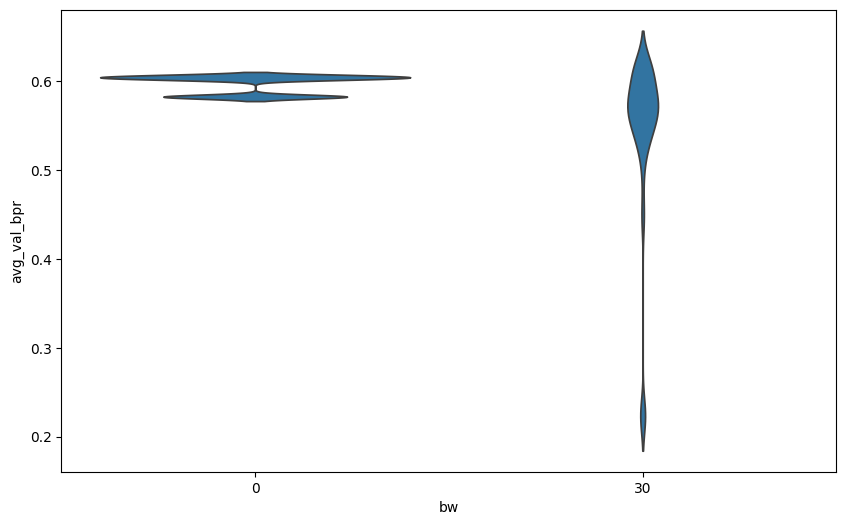

In [52]:
# makea violin plot of exploded data using x and y
plt.figure(figsize=(10, 6))
sns.violinplot(x='bw', y='avg_val_bpr', data=plot_data, inner=None, cut=2, bw=0.2)

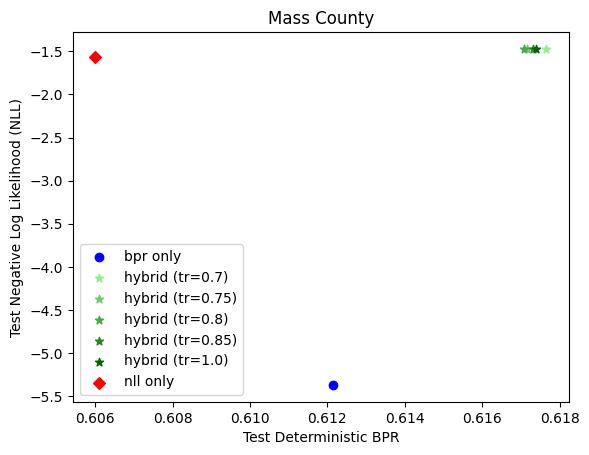

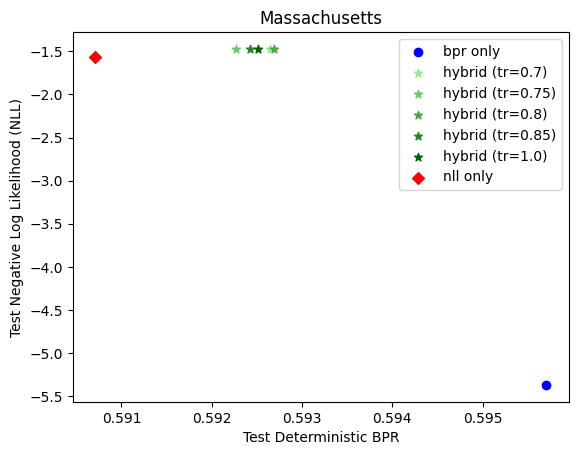

In [ ]:
# plot the final test_det_bpr and -test_nll for all models, use a different color and marker for
# bw = 30, nw=0 call this bpr only
# bw = 30, nw=1 call this hybrid
# bw = 0, nw=1 call this nll only
# don't do 0 and 0
import matplotlib.colors as mcolors

# Extract 'tr' values from results_df['param_8']
results_df['tr'] = results_df[8].apply(lambda x: float(x[0][2:]) if isinstance(x, list) and len(x) > 0 else np.nan)

# Extract 'bw' and 'nw' values from param_1 and param_2
results_df['bw'] = results_df[1].apply(lambda x: int(x[0][2:]) if isinstance(x, list) and len(x) > 0 else np.nan)
results_df['nw'] = results_df[2].apply(lambda x: int(x[0][2:]) if isinstance(x, list) and len(x) > 0 else np.nan)

# Define colors and markers
colors = { (30, 0): 'blue', (30, 1): 'green', (0, 1): 'red' }
markers = { (30, 0): 'o', (30, 1): '*', (0, 1): 'D' }
labelslist = { (30, 0): 'bpr only', (30, 1): 'hybrid', (0, 1): 'nll only' }

# Generate shades of green for different thresholds
thresholds = sorted(results_df['tr'].dropna().unique())
shades_of_green = list(mcolors.LinearSegmentedColormap.from_list("", ["lightgreen", "darkgreen"])(np.linspace(0, 1, len(thresholds))))

# Plot data points
for bw, nw in [(30, 0), (30, 1), (0, 1)]:
    mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
    if bw == 30 and nw == 0:
        idx = results_df[mask]['avg_val_bpr'].idxmax()
        plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
    elif bw == 30 and nw == 1:
        for i, tr in enumerate(thresholds):
            tr_mask = mask & (results_df['tr'] == tr)
            idx = results_df[tr_mask]['avg_val_bpr'].idxmax()
            plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                        color=shades_of_green[i], marker=markers[(bw, nw)], label=f"{labelslist[(bw, nw)]} (tr={tr})")
    elif bw == 0 and nw == 1:
        idx = results_df[mask]['avg_val_bpr'].idxmax()
        plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])

# Set labels and legend
plt.title('Massachusetts')
plt.xlabel('Test Deterministic BPR')
plt.ylabel('Test Negative Log Likelihood (NLL)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
plt.legend(by_label.values(), by_label.keys())
plt.show()
# Plot the test nll and bpr, but choose models based on the best val_det_bpr
for bw, nw in [(30, 0), (30, 1), (0, 1)]:
    mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
    if bw == 30 and nw == 0:
        idx = results_df[mask]['avg_val_bpr'].idxmax()
        plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
    elif bw == 30 and nw == 1:
        for i, tr in enumerate(thresholds):
            tr_mask = mask & (results_df['tr'] == tr)
            idx = results_df[tr_mask]['avg_val_bpr'].idxmax()
            plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                        color=shades_of_green[i], marker=markers[(bw, nw)], label=f"{labelslist[(bw, nw)]} (tr={tr})")
    elif bw == 0 and nw == 1:
        idx = results_df[mask]['avg_val_bpr'].idxmax()
        plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])

# Set labels and legend
plt.title('Massachusetts, Average test performance selected by best average val performance. 1000 rankings samples, 1000 trials')
plt.xlabel('Test Deterministic BPR')
plt.ylabel('Test Negative Log Likelihood (NLL)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
plt.legend(by_label.values(), by_label.keys())
plt.show()

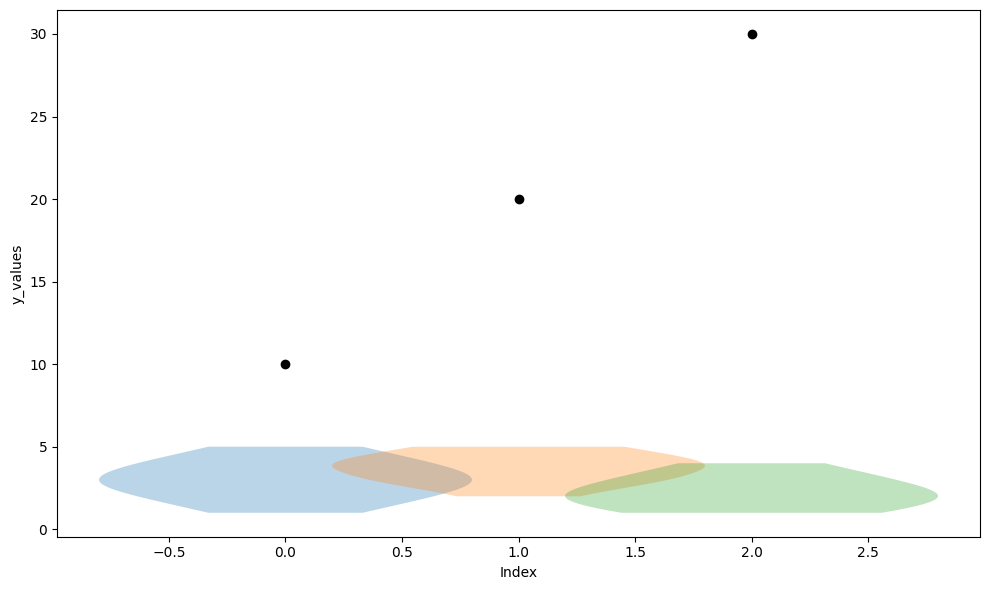

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def scatter_violin_plot(df, y_column, distribution_column, figsize=(10, 6), violin_width=0.8):
    """
    Create a scatter plot where each point has an embedded violin plot showing the distribution.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input DataFrame
    y_column : str
        Name of the column containing y-axis values
    distribution_column : str
        Name of the column containing lists of values for violin plots
    figsize : tuple
        Figure size (width, height)
    violin_width : float
        Width scaling factor for violin plots
    """
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot each point and its distribution
    for idx, row in df.iterrows():
        y_pos = row[y_column]
        distribution = np.array(row[distribution_column])
        
        # Calculate kernel density estimation
        kde = gaussian_kde(distribution)
        x_grid = np.linspace(min(distribution), max(distribution), 100)
        density = kde(x_grid)
        
        # Scale density for visualization
        density = density / density.max() * violin_width
        
        # Create violin shape
        ax.fill_betweenx(x_grid, idx - density, idx + density, alpha=0.3)
        
        # Plot center point
        ax.scatter(idx, y_pos, color='black', zorder=3)
    
    # Customize plot
    ax.set_xlabel('Index')
    ax.set_ylabel(y_column)
    plt.tight_layout()
    
    return fig, ax

# Example usage:
import pandas as pd

# Create sample data
data = {
    'y_values': [10, 20, 30],
    'distributions': [
        [1, 2, 2, 3, 3, 3, 4, 4, 5],
        [2, 3, 3, 3, 4, 4, 4, 4, 5, 5],
        [1, 1, 2, 2, 2, 3, 3, 4]
    ]
}

df = pd.DataFrame(data)

# Create the plot
fig, ax = scatter_violin_plot(df, 'y_values', 'distributions')
plt.show()

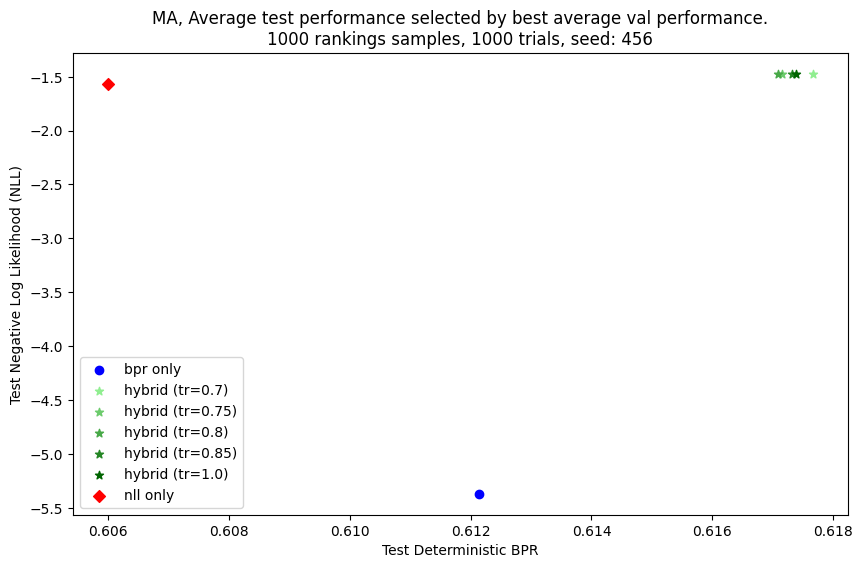

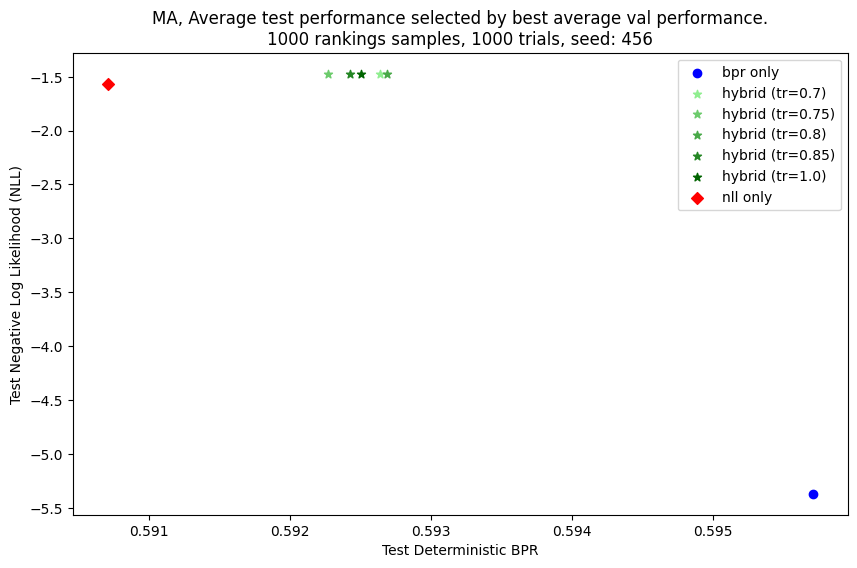

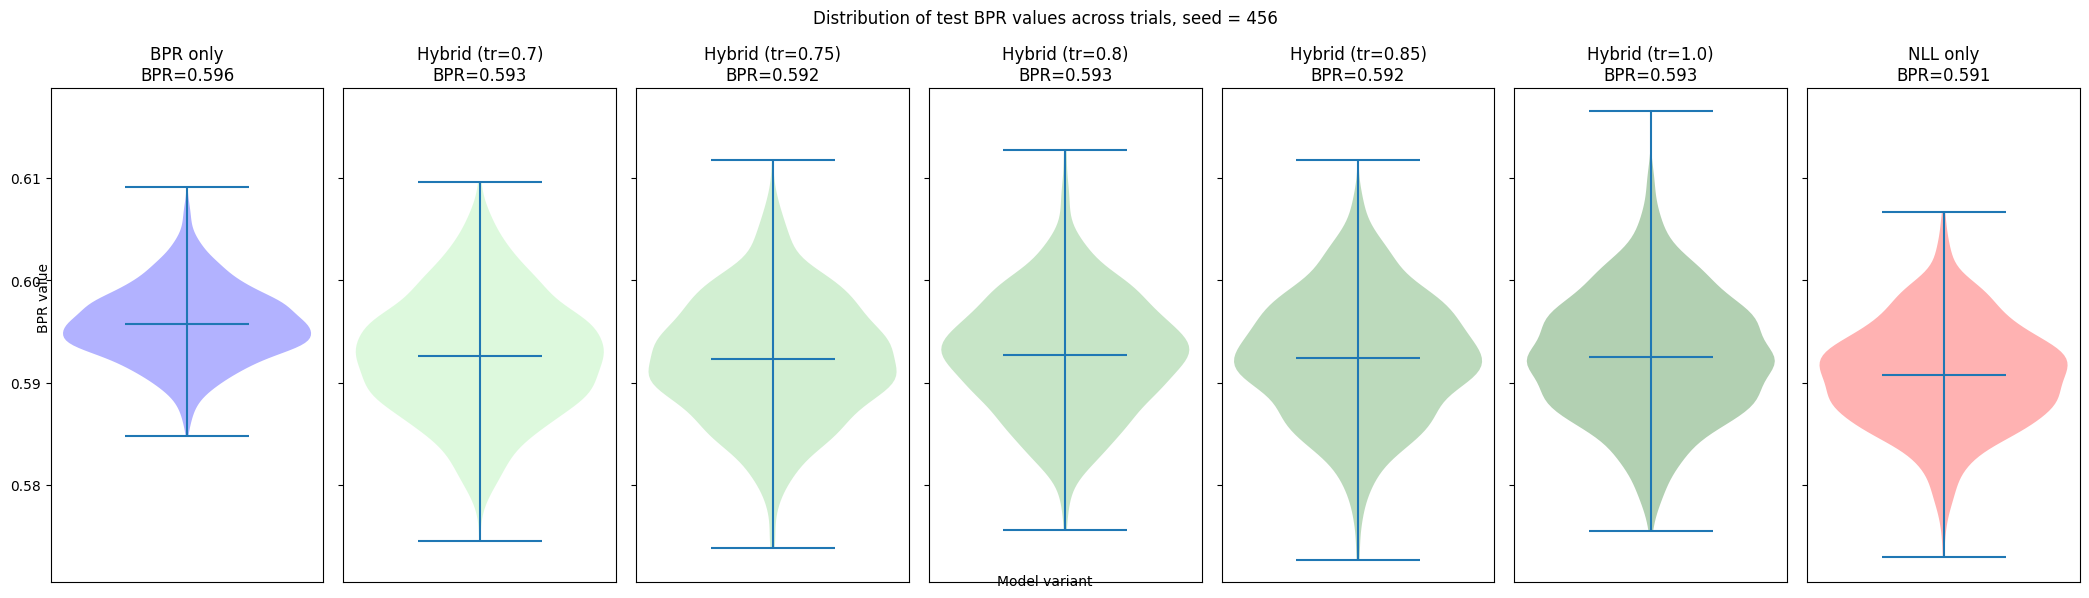

In [ ]:
# First figure: Scatter plot
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Plot data points (scatter only)
for bw, nw in [(30, 0), (30, 1), (0, 1)]:
    mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
    if bw == 30 and nw == 0:
        idx = results_df[mask]['avg_val_bpr'].idxmax()
        plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
    elif bw == 30 and nw == 1:
        for i, tr in enumerate(thresholds):
            tr_mask = mask & (results_df['tr'] == tr)
            idx = results_df[tr_mask]['avg_val_bpr'].idxmax()
            plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                        color=shades_of_green[i], marker=markers[(bw, nw)], 
                        label=f"{labelslist[(bw, nw)]} (tr={tr})")
    elif bw == 0 and nw == 1:
        idx = results_df[mask]['avg_val_bpr'].idxmax()
        plt.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])

plt.title(f'{location}, Average val performance selected by best average val performance.\n'
          f'{num_ranking_samples} rankings samples, {num_trials} trials, seed: {seed}')
plt.xlabel('Test Deterministic BPR')
plt.ylabel('Test Negative Log Likelihood (NLL)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
plt.legend(by_label.values(), by_label.keys())
plt.savefig(f'results_seed_{seed}_val_scatter.png')

# First figure: Scatter plot
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Plot data points (scatter only)
for bw, nw in [(30, 0), (30, 1), (0, 1)]:
    mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
    if bw == 30 and nw == 0:
        idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
        plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
    elif bw == 30 and nw == 1:
        for i, tr in enumerate(thresholds):
            tr_mask = mask & (results_df['tr'] == tr)
            idx = results_df[tr_mask]['avg_val_bpr'].idxmax()  # Changed to test
            plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                        color=shades_of_green[i], marker=markers[(bw, nw)], 
                        label=f"{labelslist[(bw, nw)]} (tr={tr})")
    elif bw == 0 and nw == 1:
        idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
        plt.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])

plt.title(f'{location}, Average test performance selected by best average val performance.\n'
          f'{num_ranking_samples} rankings samples, {num_trials} trials, seed: {seed}')
plt.xlabel('Test Deterministic BPR')
plt.ylabel('Test Negative Log Likelihood (NLL)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
plt.legend(by_label.values(), by_label.keys())
plt.savefig(f'results_seed_{seed}_test_scatter.png')

# Second figure: Violin plots
total_points = (
    1 +  # bpr only
    len(thresholds) +  # hybrid (one for each threshold)
    1  # nll only
)

fig2, axes = plt.subplots(1, total_points, figsize=(3*total_points, 6), sharey=True)
plot_idx = 0

# Get global min/max for y-axis limits
all_bpr_values = []
for bw, nw in [(30, 0), (30, 1), (0, 1)]:
    mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
    if bw == 30 and nw == 0:
        idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
        all_bpr_values.extend(trial_test_bprs[idx])  # Changed to test
    elif bw == 30 and nw == 1:
        for tr in thresholds:
            tr_mask = mask & (results_df['tr'] == tr)
            idx = results_df[tr_mask]['avg_val_bpr'].idxmax()  # Changed to test
            all_bpr_values.extend(trial_test_bprs[idx])  # Changed to test
    elif bw == 0 and nw == 1:
        idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
        all_bpr_values.extend(trial_test_bprs[idx])  # Changed to test

y_min, y_max = min(all_bpr_values), max(all_bpr_values)
y_range = y_max - y_min
y_padding = y_range * 0.05

# Plot violin plots
for bw, nw in [(30, 0), (30, 1), (0, 1)]:
    mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
    if bw == 30 and nw == 0:
        idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
        ax = axes[plot_idx]
        ax.violinplot(trial_test_bprs[idx], showmeans=True)  # Changed to test
        ax.set_title(f'BPR only\nBPR={results_df.loc[idx, "avg_test_bpr"]:.3f}')  # Changed to test
        ax.collections[0].set_facecolor(colors[(bw, nw)])
        plot_idx += 1
    elif bw == 30 and nw == 1:
        for i, tr in enumerate(thresholds):
            tr_mask = mask & (results_df['tr'] == tr)
            idx = results_df[tr_mask]['avg_val_bpr'].idxmax()  # Changed to test
            ax = axes[plot_idx]
            ax.violinplot(trial_test_bprs[idx], showmeans=True)  # Changed to test
            ax.set_title(f'DAML (tr={tr})\nBPR={results_df.loc[idx, "avg_test_bpr"]:.3f}')  # Changed to test
            ax.collections[0].set_facecolor(shades_of_green[i])
            plot_idx += 1
    elif bw == 0 and nw == 1:
        idx = results_df[mask]['avg_val_bpr'].idxmax()  # Changed to test
        ax = axes[plot_idx]
        ax.violinplot(trial_test_bprs[idx], showmeans=True)  # Changed to test
        ax.set_title(f'NLL only\nBPR={results_df.loc[idx, "avg_test_bpr"]:.3f}')  # Changed to test
        ax.collections[0].set_facecolor(colors[(bw, nw)])
        plot_idx += 1

# Set common y limits for all plots
for ax in axes:
    ax.set_ylim(y_min - y_padding, y_max + y_padding)
    ax.set_xticks([])

# Set common labels for violin plots
fig2.suptitle(f'Distribution of test BPR values across trials, seed = {seed}')
fig2.text(0.5, 0.02, 'Model variant', ha='center')
fig2.text(0.02, 0.5, 'BPR value', va='center', rotation='vertical')

plt.tight_layout()
plt.savefig(f'results_seed_{seed}_test_violins.png')
plt.show()

In [26]:
results_df = pd.read_csv('results_seed_123_cook.csv')

In [27]:
results_df.sort_values('avg_val_bpr', ascending=False).head(10)

,model_path,avg_val_bpr,avg_test_bpr,trial_val_bprs,trial_test_bprs,val_nll,test_nll,param_0,param_1,param_2,param_3,param_4,param_5,param_6,param_7,param_8
141,/cluster/tufts/hugheslab/kheuto01/opioid_hpc_t...,0.836202,0.805107,"[array(0.8265802, dtype=float32), array(0.8395...","[array(0.8032677, dtype=float32), array(0.8077...",2.987862,3.688233,['K100'],['bw30'],['nw1'],['ss0.01'],['nss100'],['nps100'],['seed123'],['sig0.001'],['tr0.8']
37,/cluster/tufts/hugheslab/kheuto01/opioid_hpc_t...,0.829974,0.818318,"[array(0.8298217, dtype=float32), array(0.8330...","[array(0.8208944, dtype=float32), array(0.8200...",13.145906,17.197218,['K100'],['bw30'],['nw0'],['ss0.01'],['nss100'],['nps100'],['seed123'],['sig0.01'],NaN
171,/cluster/tufts/hugheslab/kheuto01/opioid_hpc_t...,0.829266,0.800577,"[array(0.828201, dtype=float32), array(0.82982...","[array(0.79956186, dtype=float32), array(0.800...",3.050821,3.685815,['K100'],['bw30'],['nw1'],['ss0.01'],['nss200'],['nps100'],['seed123'],['sig0.001'],['tr0.8']
170,/cluster/tufts/hugheslab/kheuto01/opioid_hpc_t...,0.829165,0.800568,"[array(0.8265802, dtype=float32), array(0.8314...","[array(0.8002782, dtype=float32), array(0.8010...",3.050821,3.685815,['K100'],['bw30'],['nw1'],['ss0.01'],['nss200'],['nps100'],['seed123'],['sig0.001'],['tr0.75']
173,/cluster/tufts/hugheslab/kheuto01/opioid_hpc_t...,0.829094,0.800450,"[array(0.83468395, dtype=float32), array(0.831...","[array(0.8002782, dtype=float32), array(0.8002...",3.050821,3.685815,['K100'],['bw30'],['nw1'],['ss0.01'],['nss200'],['nps100'],['seed123'],['sig0.001'],['tr1']
172,/cluster/tufts/hugheslab/kheuto01/opioid_hpc_t...,0.829037,0.800512,"[array(0.8298217, dtype=float32), array(0.8265...","[array(0.79956186, dtype=float32), array(0.800...",3.050821,3.685815,['K100'],['bw30'],['nw1'],['ss0.01'],['nss200'],['nps100'],['seed123'],['sig0.001'],['tr0.85']
45,/cluster/tufts/hugheslab/kheuto01/opioid_hpc_t...,0.824214,0.811241,"[array(0.82333875, dtype=float32), array(0.823...","[array(0.8115821, dtype=float32), array(0.8115...",165.887860,276.441350,['K100'],['bw30'],['nw0'],['ss0.01'],['nss200'],['nps200'],['seed123'],['sig0.001'],NaN
40,/cluster/tufts/hugheslab/kheuto01/opioid_hpc_t...,0.820404,0.812875,"[array(0.82009727, dtype=float32), array(0.820...","[array(0.8119569, dtype=float32), array(0.8155...",6.379793,8.375804,['K100'],['bw30'],['nw0'],['ss0.01'],['nss100'],['nps200'],['seed123'],['sig0.01'],NaN
42,/cluster/tufts/hugheslab/kheuto01/opioid_hpc_t...,0.819759,0.802754,"[array(0.8168557, dtype=float32), array(0.8217...","[array(0.7986592, dtype=float32), array(0.8008...",5.504785,7.206069,['K100'],['bw30'],['nw0'],['ss0.01'],['nss200'],['nps100'],['seed123'],['sig0.001'],NaN
44,/cluster/tufts/hugheslab/kheuto01/opioid_hpc_t...,0.818900,0.817967,"[array(0.8184765, dtype=float32), array(0.8184...","[array(0.81796694, dtype=float32), array(0.817...",1015.354550,1211.868500,['K100'],['bw30'],['nw0'],['ss0.01'],['nss200'],['nps100'],['seed123'],['sig0.1'],NaN


In [179]:
import os
import torch
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import gaussian_kde

def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

def check_existing_results(seed, location, K):
    return os.path.exists(f'results_seed_{seed}_{location}_{K}.csv')

def load_results(seed, location, K):
    safe_globals = {
        'array': np.array,
        'float32': np.float32,
        'nan': np.nan,
        'inf': np.inf
    }

    def type_converter(x):
        if pd.isna(x):
            return np.nan
        try:
            return eval(x, safe_globals)
        except (SyntaxError, ValueError):
            try:
                return ast.literal_eval(x)
            except (SyntaxError, ValueError):
                return x

    return pd.read_csv(f'results_seed_{seed}_{location}_{K}.csv', converters={
        'avg_val_bpr': type_converter,
        'avg_test_bpr': type_converter,
        'trial_val_bprs': type_converter,
        'trial_test_bprs': type_converter,
        'val_nll': type_converter,
        'test_nll': type_converter,
        'param_1': type_converter,
        'param_2': type_converter,
        'param_8': type_converter
    })

def process_experiment_directory(exp_dir, max_param_len, data, device, num_trials, num_ranking_samples, K, val_data, test_data):
    dir_name = os.path.basename(exp_dir)
    params = [param.split('_') for param in dir_name.split('_')]
    model_path = os.path.join(exp_dir, 'best_model.pth')

    if not os.path.exists(model_path):
        return None

    model = NegativeBinomialRegressionModel(
        num_locations=data['train'][0].shape[1],
        num_fixed_effects=data['train'][0].shape[2]
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    trial_val_bpr = []
    trial_test_bpr = []
    val_nll = -model.log_likelihood(val_data[2], val_data[0], val_data[1]).detach().cpu().numpy()
    test_nll = -model.log_likelihood(test_data[2], test_data[0], test_data[1]).detach().cpu().numpy()

    for trial in range(num_trials):
        val_dist = model(val_data[0], val_data[1])
        y_sample_TMS = val_dist.sample((num_ranking_samples,)).permute(1, 0, 2)
        ratio_rating_TMS = y_sample_TMS / y_sample_TMS.sum(dim=-1, keepdim=True)
        ratio_rating_TS = ratio_rating_TMS.mean(dim=1)
        det_bpr = deterministic_bpr(ratio_rating_TS, val_data[2], K=K)
        trial_val_bpr.append(torch.mean(det_bpr).cpu().numpy())

        test_dist = model(test_data[0], test_data[1])
        y_sample_TMS = test_dist.sample((num_ranking_samples,)).permute(1, 0, 2)
        ratio_rating_TMS = y_sample_TMS / y_sample_TMS.sum(dim=-1, keepdim=True)
        ratio_rating_TS = ratio_rating_TMS.mean(dim=1)
        det_bpr = deterministic_bpr(ratio_rating_TS, test_data[2], K=K)
        trial_test_bpr.append(torch.mean(det_bpr).cpu().numpy())

    avg_val_bpr = np.mean(trial_val_bpr)
    avg_test_bpr = np.mean(trial_test_bpr)

    return {
        'model_path': model_path,
        'avg_val_bpr': avg_val_bpr,
        'avg_test_bpr': avg_test_bpr,
        'trial_val_bprs': trial_val_bpr,
        'trial_test_bprs': trial_test_bpr,
        'val_nll': val_nll,
        'test_nll': test_nll,
        'params': params
    }

def save_results(results, params_list, max_param_len, seed, location, K):
    params_df = pd.DataFrame(params_list, columns=[f'param_{i}' for i in range(max_param_len)])
    results_df = pd.concat([results, params_df], axis=1)
    results_df.to_csv(f'results_seed_{seed}_{location}_{K}.csv', index=False)

def run_experiment(seed, location, K, exp_dirs, data, device, num_trials, num_ranking_samples, val_data, test_data):
    setup_seed(seed)

    if check_existing_results(seed, location, K):
        results_df = load_results(seed, location, K)
    else:
        results = []
        params_list = []
        max_param_len = 0

        for e, exp_dir in enumerate(exp_dirs):
            if e % 5 == 0:
                print(f'Processing experiment {e} of {len(exp_dirs)}')

            result = process_experiment_directory(exp_dir, max_param_len, data, device, num_trials, num_ranking_samples, K, val_data, test_data)
            if result:
                results.append(result)
                params_list.append(result['params'])
                max_param_len = max(max_param_len, len(result['params']))

        results_df = pd.DataFrame(results)
        save_results(results_df, params_list, max_param_len, seed, location, K)

    # Add additional processing here as needed
    return results_df

def extract_parameters(results_df):
    results_df['tr'] = results_df['param_8'].apply(lambda x: float(x[0][2:]) if isinstance(x, list) and len(x) > 0 and len(x[0]) < 8 else np.nan)
    results_df['bw'] = results_df['param_1'].apply(lambda x: int(x[0][2:]) if isinstance(x, list) and len(x) > 0 else np.nan)
    results_df['nw'] = results_df['param_2'].apply(lambda x: int(x[0][2:]) if isinstance(x, list) and len(x) > 0 else np.nan)
    return results_df
def generate_colors_and_markers():
    colors = { (30, 0): '#1f77b4', (30, 1): '#ff7f0e', (0, 1): '#2ca02c' }
    markers = { (30, 0): 'o', (30, 1): 's', (0, 1): '^' }
    labelslist = { (30, 0): 'BPR Only', (30, 1): 'DAML', (0, 1): 'NLL Only' }
    return colors, markers, labelslist

def plot_test_scatter_with_kde(results_df, location, num_ranking_samples, num_trials, seed, K, title_string=None, violin_height=1, legend_loc='best'):
    colors, markers, labelslist = generate_colors_and_markers()
    thresholds = sorted(results_df['tr'].dropna().unique())
    shades_of_orange = list(mcolors.LinearSegmentedColormap.from_list("", ["#fd8d3c", "#f03b20"])(np.linspace(0, 1, len(thresholds))))

    fig, ax = plt.subplots(figsize=(6, 5))

    for bw, nw in [(30, 0), (30, 1), (0, 1)]:
        mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
        if bw == 30 and nw == 0:
            idx = results_df[mask]['avg_val_bpr'].idxmax()
            kde = gaussian_kde(results_df.loc[idx, 'trial_test_bprs'])
            x_range = np.linspace(min(results_df.loc[idx, 'trial_test_bprs']), max(results_df.loc[idx, 'trial_test_bprs']), 200)
            density = kde(x_range)
            density /= density.max()
            density *= violin_height
            y_lower = -results_df.loc[idx, 'test_nll'] - violin_height / 2
            ax.fill_between(x=x_range, y1=y_lower, y2=y_lower + density, color=colors[(bw, nw)], alpha=0.5)
            ax.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                       color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
        elif bw == 30 and nw == 1:
            for i, tr in enumerate(thresholds):
                tr_mask = mask & (results_df['tr'] == tr)
                idx = results_df[tr_mask]['val_nll'].idxmin()
                kde = gaussian_kde(results_df.loc[idx, 'trial_test_bprs'])
                x_range = np.linspace(min(results_df.loc[idx, 'trial_test_bprs']), max(results_df.loc[idx, 'trial_test_bprs']), 200)
                density = kde(x_range)
                density /= density.max()
                density *= violin_height
                y_lower = -results_df.loc[idx, 'test_nll'] - violin_height / 2
                ax.fill_between(x=x_range, y1=y_lower, y2=y_lower + density, color=shades_of_orange[i], alpha=0.5)
                print(f'Threshold: {tr}, BPR: {results_df.loc[idx, "avg_test_bpr"]}, NLL: {results_df.loc[idx, "test_nll"]}')
                ax.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                           color=shades_of_orange[i], marker=markers[(bw, nw)], 
                           label=f"{labelslist[(bw, nw)]} ($\\epsilon$={tr:.2f})")
        elif bw == 0 and nw == 1:
            idx = results_df[mask]['val_nll'].idxmin()
            kde = gaussian_kde(results_df.loc[idx, 'trial_test_bprs'])
            x_range = np.linspace(min(results_df.loc[idx, 'trial_test_bprs']), max(results_df.loc[idx, 'trial_test_bprs']), 200)
            density = kde(x_range)
            density /= density.max()
            density *= violin_height
            y_lower = -results_df.loc[idx, 'test_nll'] - violin_height / 2
            ax.fill_between(x=x_range, y1=y_lower, y2=y_lower + density, color=colors[(bw, nw)], alpha=0.5)
            ax.scatter(results_df.loc[idx, 'avg_test_bpr'], -results_df.loc[idx, 'test_nll'], 
                       color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])

    if title_string is None:
        title_string = f'{location}, Average Test Performance\nSelected by Best Average Validation Performance'
    ax.set_title(title_string, fontsize=16)
    ax.set_xlabel('Test BPR', fontsize=14)
    ax.set_ylabel('Test Log Likelihood', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)



    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
    ax.legend(by_label.values(), by_label.keys(), fontsize=12, loc=legend_loc)
    
    # set ylim
    #ax.set_ylim(-30,0)

    plt.tight_layout()
    plt.savefig(f'results_seed_{seed}_test_scatter_{location}_{K}.png', dpi=300)
    plt.show()


def plot_scatter(results_df, location, num_ranking_samples, num_trials, seed, K):
    colors, markers, labelslist = generate_colors_and_markers()
    thresholds = sorted(results_df['tr'].dropna().unique())
    shades_of_green = list(mcolors.LinearSegmentedColormap.from_list("", ["lightgreen", "darkgreen"])(np.linspace(0, 1, len(thresholds))))

    fig, ax = plt.subplots(figsize=(10, 6))

    for bw, nw in [(30, 0), (30, 1), (0, 1)]:
        mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
        if bw == 30 and nw == 0:
            idx = results_df[mask]['avg_val_bpr'].idxmax()
            ax.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                       color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])
        elif bw == 30 and nw == 1:
            for i, tr in enumerate(thresholds):
                tr_mask = mask & (results_df['tr'] == tr)
                idx = results_df[tr_mask]['avg_val_bpr'].idxmax()
                ax.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                           color=shades_of_green[i], marker=markers[(bw, nw)], 
                           label=f"{labelslist[(bw, nw)]} (tr={tr})")
        elif bw == 0 and nw == 1:
            idx = results_df[mask]['avg_val_bpr'].idxmax()
            ax.scatter(results_df.loc[idx, 'avg_val_bpr'], -results_df.loc[idx, 'test_nll'], 
                       color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labelslist[(bw, nw)])

    ax.set_title(f'{location}, Average val performance selected by best average val performance.\n'
                 f'{num_ranking_samples} rankings samples, {num_trials} trials, seed: {seed}')
    ax.set_xlabel(f'Test BPR-{K}')
    ax.set_ylabel('Test Negative Log Likelihood (NLL)')
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
    ax.legend(by_label.values(), by_label.keys())
    plt.savefig(f'results_seed_{seed}_val_scatter_{location}_{K}.png')




def plot_violin(results_df, location, seed, K):
    colors, markers, labelslist = generate_colors_and_markers()
    thresholds = sorted(results_df['tr'].dropna().unique())
    shades_of_green = list(mcolors.LinearSegmentedColormap.from_list("", ["lightgreen", "darkgreen"])(np.linspace(0, 1, len(thresholds))))

    total_points = 1 + len(thresholds) + 1
    fig, axes = plt.subplots(1, total_points, figsize=(3 * total_points, 6), sharey=True)
    plot_idx = 0

    all_bpr_values = []
    for bw, nw in [(30, 0), (30, 1), (0, 1)]:
        mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
        if bw == 30 and nw == 0:
            idx = results_df[mask]['avg_val_bpr'].idxmax()
            all_bpr_values.extend(results_df.loc[idx, 'trial_test_bprs'])
        elif bw == 30 and nw == 1:
            for tr in thresholds:
                tr_mask = mask & (results_df['tr'] == tr)
                idx = results_df[tr_mask]['avg_val_bpr'].idxmax()
                all_bpr_values.extend(results_df.loc[idx, 'trial_test_bprs'])
        elif bw == 0 and nw == 1:
            idx = results_df[mask]['avg_val_bpr'].idxmax()
            all_bpr_values.extend(results_df.loc[idx, 'trial_test_bprs'])

    y_min, y_max = min(all_bpr_values), max(all_bpr_values)
    y_range = y_max - y_min
    y_padding = y_range * 0.05

    for bw, nw in [(30, 0), (30, 1), (0, 1)]:
        mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
        if bw == 30 and nw == 0:
            idx = results_df[mask]['avg_val_bpr'].idxmax()
            ax = axes[plot_idx]
            ax.violinplot(results_df.loc[idx, 'trial_test_bprs'], showmeans=True)
            ax.set_title(f'BPR only\nBPR={results_df.loc[idx, "avg_test_bpr"]:.3f}')
            ax.collections[0].set_facecolor(colors[(bw, nw)])
            plot_idx += 1
        elif bw == 30 and nw == 1:
            for i, tr in enumerate(thresholds):
                tr_mask = mask & (results_df['tr'] == tr)
                idx = results_df[tr_mask]['avg_val_bpr'].idxmax()
                ax = axes[plot_idx]
                ax.violinplot(results_df.loc[idx, 'trial_test_bprs'], showmeans=True)
                ax.set_title(f'Hybrid (t={tr})\nBPR={results_df.loc[idx, "avg_test_bpr"]:.3f}')
                ax.collections[0].set_facecolor(shades_of_green[i])
                plot_idx += 1
        elif bw == 0 and nw == 1:
            idx = results_df[mask]['avg_val_bpr'].idxmax()
            ax = axes[plot_idx]
            ax.violinplot(results_df.loc[idx, 'trial_test_bprs'], showmeans=True)
            ax.set_title(f'NLL only\nBPR={results_df.loc[idx, "avg_test_bpr"]:.3f}')
            ax.collections[0].set_facecolor(colors[(bw, nw)])
            plot_idx += 1

    for ax in axes:
        ax.set_ylim(y_min - y_padding, y_max + y_padding)
        ax.set_xticks([])

    fig.suptitle(f'{location} Distribution of test BPR values across trials, seed = {seed}')
    fig.text(0.5, 0.02, 'Model variant', ha='center')
    fig.text(0.02, 0.5, 'BPR value', va='center', rotation='vertical')

    plt.tight_layout()
    plt.savefig(f'results_seed_{seed}_test_violins_{location}_{K}.png')
    plt.show()

# Usage:



In [173]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from scipy.stats import gaussian_kde

def plot_test_scatter_with_kde(results_df, location, num_ranking_samples, num_trials, seed, K, title_string=None, violin_height=1, legend_loc='lower left', break_point=None, upper_ylim=None, lower_ylim=None):
    colors, markers, labelslist = generate_colors_and_markers()
    thresholds = sorted(results_df['tr'].dropna().unique())
    shades_of_orange = list(mcolors.LinearSegmentedColormap.from_list("", ["#fd8d3c", "#f03b20"])(np.linspace(0, 1, len(thresholds))))

    selection_criteria = {
        (30, 0): ('avg_val_bpr', 'max'),
        (30, 1): ('avg_val_bpr', 'max'),
        (0, 1): ('val_nll', 'min')
    }

    if break_point is not None:
        fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 5), gridspec_kw={'height_ratios': [3, 1]})
    else:
        fig, ax = plt.subplots(figsize=(6, 5))
        ax2 = None

    all_handles, all_labels = [], []
    
    for bw, nw in selection_criteria.keys():
        column, operation = selection_criteria[(bw, nw)]
        mask = (results_df['bw'] == bw) & (results_df['nw'] == nw)
        for i, tr in enumerate(thresholds if bw == 30 and nw == 1 else [None]):
            tr_mask = mask & (results_df['tr'] == tr) if tr is not None else mask
            idx = results_df[tr_mask][column].idxmax() if operation == 'max' else results_df[tr_mask][column].idxmin()
            
            kde = gaussian_kde(results_df.loc[idx, 'trial_test_bprs'])
            x_range = np.linspace(min(results_df.loc[idx, 'trial_test_bprs']), max(results_df.loc[idx, 'trial_test_bprs']), 200)
            density = kde(x_range)
            density /= density.max()
            density *= violin_height
            y_value = -results_df.loc[idx, 'test_nll']

            ax_to_use = ax2 if break_point is not None and y_value < break_point else ax

            y_lower = y_value - violin_height / 2
            y_upper = y_lower + density
            color = shades_of_orange[i] if tr is not None else colors[(bw, nw)]
            
            ax_to_use.fill_between(x=x_range, y1=y_lower, y2=y_upper, color=color, alpha=0.5, zorder=0)
            scatter = ax_to_use.scatter(results_df.loc[idx, 'avg_test_bpr'], y_value, color=color, marker=markers[(bw, nw)],
                                        label=f"{labelslist[(bw, nw)]} ($\\epsilon$={tr:.2f})" if tr is not None else labelslist[(bw, nw)], zorder=1)
            all_handles.append(scatter)
            all_labels.append(scatter.get_label())

    if title_string is None:
        title_string = f'{location}, Average Test Performance\nSelected by Best Average Validation Performance'
    ax.set_title(title_string, fontsize=16)
    ax.set_ylabel('Test Log Likelihood', fontsize=14)
    if ax2:
        ax2.set_xlabel('Test BPR', fontsize=14)
    else:
        ax.set_xlabel('Test BPR', fontsize=14)

    if break_point is not None:
        if upper_ylim is None:
            upper_ylim = (-50, 5)
        if lower_ylim is None:
            lower_ylim = (-500, -150)
        ax.set_ylim(*upper_ylim)
        ax2.set_ylim(*lower_ylim)
        ax.spines['bottom'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax.xaxis.tick_top()
        ax2.xaxis.tick_bottom()
        d = .015  # Diagonal line size
        kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
        ax.plot((-d, +d), (-d, +d), **kwargs)
        ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)
        kwargs.update(transform=ax2.transAxes)
        dy = .03  # Diagonal line size
        ax2.plot((-d, +d), (1 - dy, 1 + dy), **kwargs)
        ax2.plot((1 - d, 1 + d), (1 - dy, 1 + dy), **kwargs)

    by_label = dict(sorted(zip(all_labels, all_handles), key=lambda x: x[0]))
    fig.legend(by_label.values(), by_label.keys(), fontsize=12, loc='lower left', bbox_to_anchor=(0.13, 0.13), frameon=True)

    plt.tight_layout()  # Adjust layout without legend interference

    plt.savefig(f'results_seed_{seed}_test_scatter_{location}_{K}.png', dpi=300)
    plt.show()


Num timesteps: 9


Num timesteps: 1
Num timesteps: 2
Threshold: 0.7, BPR: 0.6101957, NLL: 1.4608899
Threshold: 0.75, BPR: 0.6097157, NLL: 1.4608899
Threshold: 0.8, BPR: 0.60973257, NLL: 1.4608899
Threshold: 0.85, BPR: 0.6098842, NLL: 1.4608899
Threshold: 1.0, BPR: 0.60989684, NLL: 1.4608899


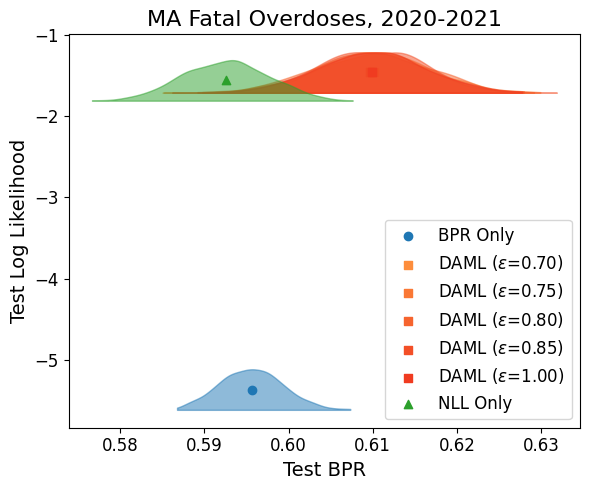

In [182]:
location = 'MA'

dirs = {'MA': ('/cluster/tufts/hugheslab/datasets/NSF_OD/cleaned/long/MA', '/cluster/tufts/hugheslab/kheuto01/opioid_hpc_test_long_big/MA/'),
        'cook': ('/cluster/tufts/hugheslab/datasets/NSF_OD/cleaned/cook', '/cluster/tufts/hugheslab/kheuto01/opioid_hpc_test_long_big/cook/'),}
data_dir, base_dir = dirs[location]


bird=False
K=100
'''

K=50
location ='asurv'
data_dir = '/cluster/tufts/hugheslab/fmuenc01/code/prob_diff_topk/data_dir/asurv/2monthly_ctxtSize5_small_5yrTrain/'
base_dir = f'/cluster/tufts/hugheslab/fmuenc01/bird_zero_rand_K{K}_8000_bigFix/{location}'
bird=True

'''
exp_dirs = glob.glob(os.path.join(base_dir, "K*"))

device = 'cuda'
#K=100
data = load_data(data_dir,bird=bird)
seed=42

num_ranking_samples = 1000
num_trials = 1000
# Move data to device
val_data = tuple(x.to(device) for x in data['val'])
test_data = tuple(x.to(device) for x in data['test'])
results_df = run_experiment(seed,location, K, exp_dirs, data, device, 1000, 1000, val_data, test_data)
results_df = extract_parameters(results_df)
#plot_scatter(results_df, location, num_ranking_samples, num_trials, seed, K)
#plot_violin(results_df, location, seed, K)

# filter results_df to avg_val_bpr > the avg_val_bpr of the best row with nw=1 and bw=0
mask = (results_df['bw'] == 0) & (results_df['nw'] == 1)
best_nw1_bw0 = results_df[mask]['avg_val_bpr'].max()
# apply this filter only to bw=30, nw=1 models, dont filter other models
mask = (results_df['bw'] == 30) & (results_df['nw'] == 1)
mask = mask | ((results_df['bw'] == 0) & (results_df['nw'] == 0))
results_df = results_df[~mask | (results_df['avg_val_bpr'] > best_nw1_bw0)]
 

plot_test_scatter_with_kde(results_df, location, num_ranking_samples, num_trials, seed, K, violin_height=0.5, 
                           title_string='MA Fatal Overdoses, 2020-2021', legend_loc='lower right')#break_point=-10, upper_ylim=(-5,0), lower_ylim=(-1541,-1539))


In [48]:
results_df[['avg_val_bpr', 'avg_test_bpr', 'val_nll', 'test_nll', 'bw', 'nw', 'tr']].to_csv("~/code/prob_diff_topk/birds_WHY_allstuff.csv")

In [54]:
results_df[['avg_val_bpr', 'avg_test_bpr', 'val_nll', 'test_nll', 'bw', 'nw', 'tr']]

,avg_val_bpr,avg_test_bpr,val_nll,test_nll,bw,nw,tr
0,0.475220,0.380496,0.418549,0.538261,0,1,NaN
1,0.468569,0.387452,0.345344,0.307173,0,1,NaN
2,0.482844,0.404690,1510.950300,1539.934000,30,0,NaN
3,0.478382,0.400460,1090.022200,1114.132100,30,0,NaN
4,0.474751,0.408058,1423.585800,1448.541700,30,0,NaN
5,0.469347,0.412030,1493.255100,1522.970000,30,0,NaN
6,0.475031,0.410764,1560.487200,1588.516000,30,0,NaN
7,0.439218,0.359946,1.844779,1.739299,30,1,0.65
8,0.442774,0.389310,1.960325,1.917460,30,1,0.75
9,0.457430,0.373971,2.213713,2.142888,30,1,0.70


In [18]:
mask = (results_df['bw'] == 30) & (results_df['nw'] == 1)
tr_mask = mask & (results_df['tr'] == 0.7)
idx = results_df[tr_mask]['val_nll'].idxmax()
kde = gaussian_kde(results_df.loc[idx, 'trial_test_bprs'])

LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

In [28]:
results_df['param_17'].values

KeyError: 'param_17'

In [21]:
idx

39

In [7]:
location ='asurv'
data_dir = '/cluster/tufts/hugheslab/fmuenc01/code/prob_diff_topk/data_dir/asurv/2monthly_ctxtSize5_small_5yrTrain/'
base_dir = f'/cluster/tufts/hugheslab/fmuenc01/bird_zero_rand_K{K}_8000_bigFix/{location}'
bird=True
K=75

exp_dirs = glob.glob(os.path.join(base_dir, "K*"))

device = 'cuda'
#K=100
data = load_data(data_dir,bird=bird)
seed=42

num_ranking_samples = 1000
num_trials = 1000
# Move data to device
train_data = tuple(x.to(device) for x in data['train'])
val_data = tuple(x.to(device) for x in data['val'])
test_data = tuple(x.to(device) for x in data['test'])

Num timesteps: 15
Num timesteps: 6
Num timesteps: 6


In [44]:
val_data[2].min()

tensor(0., device='cuda:0')

In [51]:

model_path = '/cluster/tufts/hugheslab/fmuenc01/bird_zero_rand_K50_8000_bigFix/asurv/K50_bw30_nw0_ss0.001_nss100_nps100_seed360_sig0.1_studyasurv_timescale2monthly_ctxtSize5_small_5yrTrain/best_model.pth'
model = NegativeBinomialRegressionModel(
    num_locations=data['train'][0].shape[1],
    num_fixed_effects=data['train'][0].shape[2]
).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

val_dist = model(val_data[0], val_data[1])
y_sample_TMS = val_dist.sample((num_ranking_samples,)).permute(1, 0, 2)
ratio_rating_TMS = y_sample_TMS / y_sample_TMS.sum(dim=-1, keepdim=True)
ratio_rating_TS = ratio_rating_TMS.mean(dim=1)
det_bpr = deterministic_bpr(ratio_rating_TS, val_data[2], K=K)

train_dist = model(train_data[0], train_data[1])
y_sample_TMS = train_dist.sample((num_ranking_samples,)).permute(1, 0, 2)
ratio_rating_TMS = y_sample_TMS / y_sample_TMS.sum(dim=-1, keepdim=True)
ratio_rating_TS = ratio_rating_TMS.mean(dim=1)
det_bpr = deterministic_bpr(ratio_rating_TS, train_data[2], K=K)

In [6]:
det_bpr.mean()

NameError: name 'det_bpr' is not defined

In [76]:
data['train'][0][:,:,2]

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        [3., 3., 3.,  ..., 3., 3., 3.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        [3., 3., 3.,  ..., 3., 3., 3.]])

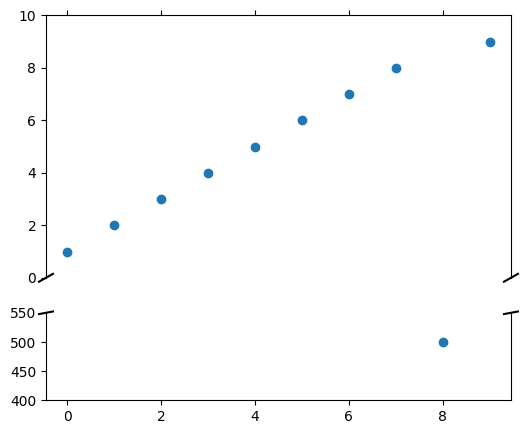

In [95]:
import matplotlib.pyplot as plt
import numpy as np

def plot_with_broken_axis():
    # Sample data
    x = np.arange(10)
    y = np.array([1, 2, 3, 4, 5, 6, 7, 8, 500, 9])  # Extreme outlier at index 8

    # Create figure and two axes
    fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 5), gridspec_kw={'height_ratios': [3, 1]})

    # Define limits for the broken axis
    ax.set_ylim(0, 10)   # Upper part
    ax2.set_ylim(400, 550)  # Lower part (outlier region)

    # Hide the broken parts of the axes
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.tick_top()
    ax2.xaxis.tick_bottom()
    
    # Add diagonal lines to indicate the break
    d = .015  # Diagonal line size
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)
    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
    
    # Plot data
    ax.scatter(x, y)
    ax2.scatter(x, y)
    
    plt.show()

# Run function
plot_with_broken_axis()
